# Обнаружение мошенничества

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import seaborn as sns
from sklearn.model_selection import train_test_split

from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report


from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from scipy.stats import ttest_rel

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score, cross_validate

from typing import List, Optional, Dict, Tuple

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data_dir = dirname + "/"
working_dir = "/kaggle/working/"

/kaggle/input/geekbrains-competitive-data-analysis/applications_history.csv
/kaggle/input/geekbrains-competitive-data-analysis/payments.csv
/kaggle/input/geekbrains-competitive-data-analysis/sample_submit.csv
/kaggle/input/geekbrains-competitive-data-analysis/bki.csv
/kaggle/input/geekbrains-competitive-data-analysis/client_profile.csv
/kaggle/input/geekbrains-competitive-data-analysis/test.csv
/kaggle/input/geekbrains-competitive-data-analysis/train.csv


In [3]:
import lightgbm as lgbm

In [4]:
import catboost as catb

## Загрузка данных

In [5]:
src_list = ["train", "test", "client_profile", "applications_history", "bki", "payments"]

In [6]:
source = {}
for name in src_list:
    source[name] = pd.read_csv(data_dir + name + ".csv")

## Ключевые характеристики

In [7]:
pd.set_option('display.max_columns', 400)

In [8]:
for name in src_list:
    print(f"{name} \n {source[name].shape} \n")

train 
 (110093, 3) 

test 
 (165141, 2) 

client_profile 
 (250000, 24) 

applications_history 
 (1670214, 26) 

bki 
 (945234, 17) 

payments 
 (1023932, 8) 



In [9]:
source['train'].head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash


In [10]:
source['client_profile'].head(3)

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549,NaN,1,0,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,365243,NaN,0,0,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,326,18.0,0,0,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
source['applications_history'].head(3)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0
2,49791680,123445379,Cash,15060.735,112500.0,136444.5,NaN,112500.0,Approved,301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,-1,12.0,high,365243.0,271.0,59.0,365243.0,365243.0,1.0


In [12]:
source['applications_history'].groupby("APPLICATION_NUMBER")["APPLICATION_NUMBER"].count().sort_values()

APPLICATION_NUMBER
123423340     1
123567999     1
123744405     1
123690209     1
123567994     1
             ..
123530122    67
123565751    68
123497019    72
123589020    73
123511207    77
Name: APPLICATION_NUMBER, Length: 338857, dtype: int64

In [13]:
source['bki'].head(3)

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,Consumer credit,39.0,NaN
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.00,0,93111.66,0.000,0.0,0.0,Consumer credit,505.0,NaN
2,123589020,6326395,Closed,currency 1,165.0,0,149.0,160.0,NaN,0,36000.00,0.000,0.0,0.0,Consumer credit,150.0,0.0


In [14]:
source['bki'].groupby("APPLICATION_NUMBER")["APPLICATION_NUMBER"].count().sort_values()

APPLICATION_NUMBER
123571743     1
123620010     1
123740077     1
123502086     1
123620015     1
             ..
123604794    36
123603494    39
123641404    50
123493043    51
123444199    63
Name: APPLICATION_NUMBER, Length: 273131, dtype: int64

In [15]:
source['bki'].groupby("APPLICATION_NUMBER")["APPLICATION_NUMBER"].count().sort_values().tail()

APPLICATION_NUMBER
123604794    36
123603494    39
123641404    50
123493043    51
123444199    63
Name: APPLICATION_NUMBER, dtype: int64

In [16]:
source['payments'].head(3)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645
2,48652024,123749925,1.0,10,8.0,23.0,5499.945,5499.945


In [17]:
source['test'].head(3)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
0,123724268,Cash
1,123456549,Cash
2,123428178,Credit Card


In [18]:
for name in src_list:
    print(f"{name} \n")
    source[name].info()
    print("\n")

train 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110093 entries, 0 to 110092
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  110093 non-null  int64 
 1   TARGET              110093 non-null  int64 
 2   NAME_CONTRACT_TYPE  110093 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.5+ MB


test 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165141 entries, 0 to 165140
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  165141 non-null  int64 
 1   NAME_CONTRACT_TYPE  165141 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.5+ MB


client_profile 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      -

In [19]:
def data_obj_discribe(data: pd.DataFrame):
# если столбец имеет тип 'object' и содержит менее 30 уникальных 
# распечатывает значения столбцов и подсчитывает количество значений

    # data: pd.DataFrame исходный датафрейм
    
    obj_fit = data.select_dtypes(include='object')
    print('*' * 100)
    for cat_colname in obj_fit.columns:
        if len(obj_fit[cat_colname].unique()) < 30:
            print(str(cat_colname) + '\n\n' + str(obj_fit[cat_colname].unique()) + '\n\n')
            print(obj_fit.groupby(cat_colname)[cat_colname].count())
            print('*' * 100 + '\n')

In [20]:
# for name in src_list:
#     obj_col = source[name].select_dtypes(include='object')
#     if not obj_col.empty:
#         print(f"\t{name}{source[name].shape}\n")
#         data_obj_discribe(source[name])

## Формируем "Большую таблицу"

### Подшиваем test к train

In [21]:
test = source['test']

In [22]:
test["TARGET"] = math.nan

In [23]:
test.head

<bound method NDFrame.head of         APPLICATION_NUMBER NAME_CONTRACT_TYPE  TARGET
0                123724268               Cash     NaN
1                123456549               Cash     NaN
2                123428178        Credit Card     NaN
3                123619984               Cash     NaN
4                123671104               Cash     NaN
...                    ...                ...     ...
165136           123487967               Cash     NaN
165137           123536402               Cash     NaN
165138           123718238               Cash     NaN
165139           123631557               Cash     NaN
165140           123433260               Cash     NaN

[165141 rows x 3 columns]>

In [24]:
data = pd.concat([source['train'], test], axis=0)
data.tail()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
165136,123487967,NaN,Cash
165137,123536402,NaN,Cash
165138,123718238,NaN,Cash
165139,123631557,NaN,Cash
165140,123433260,NaN,Cash


In [25]:
data.shape

(275234, 3)

### Добавляем client_profile

In [26]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()

    X["DAYS_ON_LAST_JOB"] = X["DAYS_ON_LAST_JOB"].replace(365243, np.nan)
#     bki_flags = [flag for flag in X.columns if "AMT_REQ_CREDIT_BUREAU" in flag]
#     X["BKI_REQUESTS_COUNT"] = X[bki_flags].sum(axis=1)
#     X["BKI_KURTOSIS"] = X[bki_flags].kurtosis(axis=1)

    X["EXTERNAL_SCORING_PROD"] = X["EXTERNAL_SCORING_RATING_1"] * X["EXTERNAL_SCORING_RATING_2"] * X["EXTERNAL_SCORING_RATING_3"]
    X["EXTERNAL_SCORING_WEIGHTED"] = X.EXTERNAL_SCORING_RATING_1 * 2 + X.EXTERNAL_SCORING_RATING_2 * 1 + X.EXTERNAL_SCORING_RATING_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "EXTERNAL_SCORING_RATING_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["EXTERNAL_SCORING_RATING_1", "EXTERNAL_SCORING_RATING_2", "EXTERNAL_SCORING_RATING_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['RATIO_CREDIT_TO_ANNUITY'] = X['AMOUNT_CREDIT'] / X['AMOUNT_ANNUITY']
    X["RATIO_ANNUITY_TO_SALARY"] = X['AMOUNT_ANNUITY'] / X['TOTAL_SALARY']
    X['RATIO_CREDIT_TO_SALARY'] = X['AMOUNT_CREDIT'] / X['TOTAL_SALARY']
    #X["TOTAL_SALARY_NET"] = X["TOTAL_SALARY"] - X["AMOUNT_ANNUITY"]

#     # Отношение фин. показателей к возрасту и временным фичам
#     X["RATIO_ANNUITY_TO_AGE"] = X["AMOUNT_ANNUITY"] / X["AGE"]
#     X["RATIO_CREDIT_TO_AGE"] = X["AMOUNT_CREDIT"] / X["AGE"]
#     X["RATIO_SALARY_TO_AGE"] = X["TOTAL_SALARY"] / X["AGE"]
#     X["RATIO_SALARY_TO_EXPERIENCE"] = X["TOTAL_SALARY"] / X["DAYS_ON_LAST_JOB"]
#     X["RATIO_CREDIT_TO_EXPERIENCE"] = X["AMOUNT_CREDIT"] / X["DAYS_ON_LAST_JOB"]
#     X["RATIO_ANNUITY_TO_EXPERIENCE"] = X["AMOUNT_ANNUITY"] / X["DAYS_ON_LAST_JOB"]

#     # Отношение врменных признаков
#     X["RATIO_AGE_TO_EXPERIENCE"] = X["AGE"] / X["DAYS_ON_LAST_JOB"]
#     X["RATIO_SALARY_TO_REGION_POPULATION"] = X["TOTAL_SALARY"] * X["REGION_POPULATION"]
#     X["RATIO_CAR_TO_EXPERIENCE"] = X["OWN_CAR_AGE"] / X["DAYS_ON_LAST_JOB"]
#     X["RATIO_CAR_TO_AGE"] = X["OWN_CAR_AGE"] / X["AGE"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["EXPECTED_TOTAL_LOSS_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_TOTAL_LOSS_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_TOTAL_LOSS_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_MONTHLY_LOSS_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_ANNUITY"]
    X["EXPECTED_MONTHLY_LOSS_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_ANNUITY"]
    X["EXPECTED_MONTHLY_LOSS_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_ANNUITY"]

    return X

In [27]:
client_profile = create_client_profile_features(source["client_profile"])
client_profile.head(n=2)

/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549.0,NaN,1,0,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0,0.052832,2.930959,0.236315,0.678568,0.414784,0.329471,0.036237,20.00000,0.085714,1.714286,88957.124333,63804.966560,183213.275945,4447.856217,3190.248328,9160.663797
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,NaN,NaN,0,0,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,0.442295,0.802745,0.622520,0.622520,0.032481,18.86105,0.105433,1.988583,NaN,237475.743779,431008.094056,NaN,12590.802122,22851.755462


In [28]:
data = pd.merge(data, client_profile, on='APPLICATION_NUMBER', how='left')
data.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
0,123687442,0.0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,0.324353,4.197193,0.645914,0.716570,0.687756,0.700784,9.169231e-04,34.025788,0.159543,5.428571,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111
1,123597908,1.0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,0.0,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,0.026392,21557.0,3618.0,NaN,1.0,0.0,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,NaN,NaN,0.267869,0.682149,0.475009,0.475009,4.290708e-02,23.603376,0.316000,7.458667,NaN,686869.876357,269722.588880,NaN,29100.493510,11427.288803
3,123710391,1.0,Cash,M,0.0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,0.031329,22338.0,NaN,NaN,0.0,0.0,2.0,NaN,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.170446,0.171299,0.170873,0.170873,1.818800e-07,22.573164,0.127625,2.880900,NaN,88829.188848,88386.882459,NaN,3935.167908,3915.573562
4,123590329,1.0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
data.tail()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
275229,123487967,NaN,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275230,123536402,NaN,Cash,M,0.0,135000.0,450000.0,16807.5,Secondary / secondary special,Single / not married,0.028663,18610.0,10398.0,23.0,0.0,0.0,1.0,NaN,0.665971,0.535276,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.535276,0.665971,0.600624,0.600624,0.004270,26.773762,0.124500,3.333333,NaN,299686.841680,240874.312713,NaN,11193.303537,8996.655580
275231,123718238,NaN,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275232,123631557,NaN,Cash,F,0.0,112500.0,350181.0,36769.5,Secondary / secondary special,Married,0.030755,20551.0,NaN,NaN,0.0,1.0,2.0,NaN,0.761376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.761376,0.761376,0.761376,0.761376,0.000000,9.523681,0.326840,3.112720,NaN,266619.257702,NaN,NaN,27995.398940,NaN
275233,123433260,NaN,Cash,M,0.0,247500.0,1241437.5,36427.5,Secondary / secondary special,Married,0.018029,18853.0,6543.0,15.0,0.0,0.0,2.0,NaN,0.493617,0.546023,0.0,0.0,0.0,1.0,0.0,2.0,NaN,NaN,0.493617,0.546023,0.519820,0.519820,0.000687,34.079679,0.147182,5.015909,NaN,612794.525674,677853.672632,NaN,17981.229489,19890.260009


In [30]:
data.shape

(275234, 42)

### Агрегируем категориальные характеристики из applications_history, bki, payments

In [31]:
def cat_encoder_m(data: pd.DataFrame)->pd.DataFrame:
    '''
    Функция для извлечения из датасета источника категориальных переменных и 
    кодирования count hot encoding
    
    data: pandas.core.frame.DataFrame
        датасет источник
        
    Возвращает датасет с колонкой APPLICATION_NUMBER и кололонками новых характеристик
    '''
    res_data = data[['APPLICATION_NUMBER']].copy()
    cat_data = data.select_dtypes(include=['object'])
    cat_list = []
    for cat_col in cat_data.columns:
        uniq_vals = cat_data[cat_col].unique()
        if len(uniq_vals) < 20:
            cat_list.append(cat_col)
            for n, uniq_val in enumerate(uniq_vals):
                new_col_name = (cat_col + '_' + str(n)).upper()  #'_'.join(str(uniq_val).split())).upper()
                res_data[new_col_name] = 0
                res_data[new_col_name][data[cat_col] == uniq_val] = 1
#                 res_data.loc[data[cat_col] == uniq_val, new_col_name] = 1  
    return res_data

In [32]:
for dat_name in src_list[5:]:
    print(dat_name)
    new_feat = cat_encoder_m(source[dat_name])
    if len(new_feat.columns) > 1:
        sum_feat = new_feat.groupby('APPLICATION_NUMBER')[new_feat.columns[1:]].sum()
        print(f"\tsum cols: {sum_feat.shape}\n")
        sum_feat.columns = [col + "_SUM" for col in sum_feat.columns]
        data = pd.merge(data, 
                        sum_feat, 
                        on='APPLICATION_NUMBER', 
                        how='left')
        mean_feat = new_feat.groupby('APPLICATION_NUMBER')[new_feat.columns[1:]].mean()
        print(f"\tmean cols: {mean_feat.shape}\n")
        mean_feat.columns = [col + "_MEAN" for col in mean_feat.columns]
        data = pd.merge(data, 
                        mean_feat, 
                        on='APPLICATION_NUMBER', 
                        how='left')

payments


In [33]:
data.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
0,123687442,0.0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,0.324353,4.197193,0.645914,0.716570,0.687756,0.700784,9.169231e-04,34.025788,0.159543,5.428571,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111
1,123597908,1.0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,0.0,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,0.026392,21557.0,3618.0,NaN,1.0,0.0,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,NaN,NaN,0.267869,0.682149,0.475009,0.475009,4.290708e-02,23.603376,0.316000,7.458667,NaN,686869.876357,269722.588880,NaN,29100.493510,11427.288803
3,123710391,1.0,Cash,M,0.0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,0.031329,22338.0,NaN,NaN,0.0,0.0,2.0,NaN,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.170446,0.171299,0.170873,0.170873,1.818800e-07,22.573164,0.127625,2.880900,NaN,88829.188848,88386.882459,NaN,3935.167908,3915.573562
4,123590329,1.0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
data.shape

(275234, 42)

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275234 entries, 0 to 275233
Data columns (total 42 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   APPLICATION_NUMBER                 275234 non-null  int64  
 1   TARGET                             110093 non-null  float64
 2   NAME_CONTRACT_TYPE                 275234 non-null  object 
 3   GENDER                             223715 non-null  object 
 4   CHILDRENS                          223715 non-null  float64
 5   TOTAL_SALARY                       223715 non-null  float64
 6   AMOUNT_CREDIT                      223715 non-null  float64
 7   AMOUNT_ANNUITY                     223704 non-null  float64
 8   EDUCATION_LEVEL                    223715 non-null  object 
 9   FAMILY_STATUS                      223715 non-null  object 
 10  REGION_POPULATION                  223715 non-null  float64
 11  AGE                                2237

### Заполняем пропуски

In [36]:
obj_col_names = data.select_dtypes(include=['object']).columns
obj_col_names

Index(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], dtype='object')

In [37]:
data.loc[data[obj_col_names[1]].isnull(), obj_col_names[1]]

1         NaN
4         NaN
10        NaN
16        NaN
17        NaN
         ... 
275225    NaN
275226    NaN
275228    NaN
275229    NaN
275231    NaN
Name: GENDER, Length: 51519, dtype: object

In [38]:
for col in obj_col_names:
    data.loc[data[col].isnull(), col] = 'No'

In [39]:
num_col_names = data.select_dtypes(exclude=['object']).columns
num_col_names

Index(['APPLICATION_NUMBER', 'TARGET', 'CHILDRENS', 'TOTAL_SALARY',
       'AMOUNT_CREDIT', 'AMOUNT_ANNUITY', 'REGION_POPULATION', 'AGE',
       'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'EXTERNAL_SCORING_PROD',
       'EXTERNAL_SCORING_WEIGHTED', 'EXTERNAL_SCORING_RATING_min',
       'EXTERNAL_SCORING_RATING_max', 'EXTERNAL_SCORING_RATING_mean',
       'EXTERNAL_SCORING_RATING_nanmedian', 'EXTERNAL_SCORING_RATING_var',
       'RATIO_CREDIT_TO_ANNUITY', 'RATIO_ANNUITY_TO_SALARY',
       'RATIO_CREDIT_TO_SALARY', 'EXPECTED_TOTAL_LOSS_1',
       'EXPECTED_TOTAL_LOSS_2', 'EXPECTED_TOTAL_LOSS_3',
       'EXPECTED_MONTHLY_LOSS_1', 'EXPECTED_MONTHLY_LOSS_2',
    

In [40]:
for col in num_col_names:
    data.loc[data[col].isnull(), col] = -1

In [41]:
data.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
0,123687442,0.0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,0.324353,4.197193,0.645914,0.716570,0.687756,0.700784,9.169231e-04,34.025788,0.159543,5.428571,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111
1,123597908,1.0,Cash,No,-1.0,-1.0,-1.0,-1.0,No,No,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,123526683,0.0,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,0.026392,21557.0,3618.0,-1.0,1.0,0.0,2.0,-1.000000,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,-1.000000,-1.000000,0.267869,0.682149,0.475009,0.475009,4.290708e-02,23.603376,0.316000,7.458667,-1.000000,686869.876357,269722.588880,-1.000000,29100.493510,11427.288803
3,123710391,1.0,Cash,M,0.0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,0.031329,22338.0,-1.0,-1.0,0.0,0.0,2.0,-1.000000,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,-1.000000,0.170446,0.171299,0.170873,0.170873,1.818800e-07,22.573164,0.127625,2.880900,-1.000000,88829.188848,88386.882459,-1.000000,3935.167908,3915.573562
4,123590329,1.0,Cash,No,-1.0,-1.0,-1.0,-1.0,No,No,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


### Агрегируем числовые приазнаки из applications_history, bki, payments

In [42]:
stats = ["count"] #, "mean", "min", "max", "std"count]

In [43]:
for dat_name in src_list[3:3]:
    print(dat_name)
    dat = source[dat_name].select_dtypes(exclude=['object'])
    for col in dat.columns[2:]:
        dat.loc[dat[col].isnull(), col] = -1
    new_feat = dat.groupby("APPLICATION_NUMBER", as_index=False)[dat.columns[2:]].agg(stats).reset_index()
    for col in new_feat.columns[1:]:
        new_feat.loc[new_feat[col].isnull(), col] = -1
    
#     print(new_feat.info())
    tmp = [new_feat.columns[0][0]]
    tmp.extend([col[0]+"_"+col[1].upper() for col in new_feat.columns[1:]])
    new_feat.columns = tmp
#     print(tmp)
#     print(new_feat.info())
    data = pd.merge(data, 
                    new_feat, 
                    on='APPLICATION_NUMBER', 
                    how='left')

In [44]:
data.shape

(275234, 42)

In [45]:
data.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
0,123687442,0.0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.71657,0.0,0.0,1.0,0.0,0.0,2.0,0.324353,4.197193,0.645914,0.71657,0.687756,0.700784,0.000917,34.025788,0.159543,5.428571,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111
1,123597908,1.0,Cash,No,-1.0,-1.0,-1.0,-1.0,No,No,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.00000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275234 entries, 0 to 275233
Data columns (total 42 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   APPLICATION_NUMBER                 275234 non-null  int64  
 1   TARGET                             275234 non-null  float64
 2   NAME_CONTRACT_TYPE                 275234 non-null  object 
 3   GENDER                             275234 non-null  object 
 4   CHILDRENS                          275234 non-null  float64
 5   TOTAL_SALARY                       275234 non-null  float64
 6   AMOUNT_CREDIT                      275234 non-null  float64
 7   AMOUNT_ANNUITY                     275234 non-null  float64
 8   EDUCATION_LEVEL                    275234 non-null  object 
 9   FAMILY_STATUS                      275234 non-null  object 
 10  REGION_POPULATION                  275234 non-null  float64
 11  AGE                                2752

### Ratios

In [47]:
# #финансовые признаки
# data["RATIO_SALARY_TO_AMOUNT_CREDIT"] = data["TOTAL_SALARY"] / data["AMOUNT_CREDIT"]
# data["RATIO_AMOUNT_ANNUITY_TO_SALARY"] = data["AMOUNT_ANNUITY"] / data["TOTAL_SALARY"]

# # семейные признаки
# data["RATIO_SALARY_TO_PER_FAMILY_SIZE"] = data["TOTAL_SALARY"] / data["FAMILY_SIZE"]

# # флаги
# data["FLG_MORE_THAN_30PERCENT_FOR_CREDIT"] = np.where(
#     data["RATIO_AMOUNT_ANNUITY_TO_SALARY"] > 0.42, 1, 0
# )

### Features Interaction

In [48]:
data["EDUCATION_FAMILY_STATUS"] = data["EDUCATION_LEVEL"] + " | " + data["FAMILY_STATUS"]

In [49]:
data.shape

(275234, 43)

### Ещё раз заполняем пропуски

In [50]:
data = data.replace(np.inf, np.nan)
data = data.replace(-np.inf, np.nan)

In [51]:
for col in data.select_dtypes(exclude=['object']).columns:
    data.loc[data[col].isnull(), col] = -1

In [52]:
data.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3,EDUCATION_FAMILY_STATUS
0,123687442,0.0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.71657,0.0,0.0,1.0,0.0,0.0,2.0,0.324353,4.197193,0.645914,0.71657,0.687756,0.700784,0.000917,34.025788,0.159543,5.428571,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111,Secondary / secondary special | Married
1,123597908,1.0,Cash,No,-1.0,-1.0,-1.0,-1.0,No,No,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.00000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,No | No


### Преобразуем категориальные признаки в числовые

In [53]:
data_cat = data.copy()

In [54]:
obj_col = data.select_dtypes(exclude=[np.number])

In [55]:
if not obj_col.empty:
    data_obj_discribe(data)

****************************************************************************************************
NAME_CONTRACT_TYPE

['Cash' 'Credit Card']


NAME_CONTRACT_TYPE
Cash           248983
Credit Card     26251
Name: NAME_CONTRACT_TYPE, dtype: int64
****************************************************************************************************

GENDER

['M' 'No' 'F' 'XNA']


GENDER
F      147444
M       76267
No      51519
XNA         4
Name: GENDER, dtype: int64
****************************************************************************************************

EDUCATION_LEVEL

['Secondary / secondary special' 'No' 'Higher education' 'Lower secondary'
 'Incomplete higher' 'Academic degree']


EDUCATION_LEVEL
Academic degree                     120
Higher education                  54516
Incomplete higher                  7456
Lower secondary                    2736
No                                51519
Secondary / secondary special    158887
Name: EDUCATION_LEVEL, dtype: int64
*

In [56]:
def data_obj_map(data: pd.DataFrame):
# если столбец имеет тип 'object' и содержит менее 30 уникальных 
# преобразует категориальные признак в числовые

    # data: pd.DataFrame исходный датафрейм
    
    # изменяет датафрейм источник
    
    obj_fit = data.select_dtypes(include='object')
    for cat_colname in obj_fit.columns:
        map_tr = {}
        un_val = obj_fit[cat_colname].unique()
        if len(un_val) < 30:
            print(str(cat_colname) + '\n')
            for i in range(len(un_val)):
                map_tr[un_val[i]] = i
            print(map_tr)
            data[cat_colname] = data[cat_colname].map(map_tr)
            print('*' * 100 + '\n')

In [57]:
if not obj_col.empty:
    data_obj_map(data)

NAME_CONTRACT_TYPE

{'Cash': 0, 'Credit Card': 1}
****************************************************************************************************

GENDER

{'M': 0, 'No': 1, 'F': 2, 'XNA': 3}
****************************************************************************************************

EDUCATION_LEVEL

{'Secondary / secondary special': 0, 'No': 1, 'Higher education': 2, 'Lower secondary': 3, 'Incomplete higher': 4, 'Academic degree': 5}
****************************************************************************************************

FAMILY_STATUS

{'Married': 0, 'No': 1, 'Single / not married': 2, 'Separated': 3, 'Civil marriage': 4, 'Widow': 5, 'Unknown': 6}
****************************************************************************************************

EDUCATION_FAMILY_STATUS

{'Secondary / secondary special | Married': 0, 'No | No': 1, 'Higher education | Married': 2, 'Secondary / secondary special | Single / not married': 3, 'Higher education | Single / not marr

In [58]:
data.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3,EDUCATION_FAMILY_STATUS
0,123687442,0.0,0,0,1.0,157500.0,855000.0,25128.0,0,0,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,0.324353,4.197193,0.645914,0.716570,0.687756,0.700784,9.169231e-04,34.025788,0.159543,5.428571,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111,0
1,123597908,1.0,0,1,-1.0,-1.0,-1.0,-1.0,1,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
2,123526683,0.0,0,2,0.0,135000.0,1006920.0,42660.0,2,0,0.026392,21557.0,3618.0,-1.0,1.0,0.0,2.0,-1.000000,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,-1.000000,-1.000000,0.267869,0.682149,0.475009,0.475009,4.290708e-02,23.603376,0.316000,7.458667,-1.000000,686869.876357,269722.588880,-1.000000,29100.493510,11427.288803,2
3,123710391,1.0,0,0,0.0,180000.0,518562.0,22972.5,0,0,0.031329,22338.0,-1.0,-1.0,0.0,0.0,2.0,-1.000000,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,-1.000000,0.170446,0.171299,0.170873,0.170873,1.818800e-07,22.573164,0.127625,2.880900,-1.000000,88829.188848,88386.882459,-1.000000,3935.167908,3915.573562,0
4,123590329,1.0,0,1,-1.0,-1.0,-1.0,-1.0,1,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1


In [59]:
data_cat.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3,EDUCATION_FAMILY_STATUS
0,123687442,0.0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.71657,0.0,0.0,1.0,0.0,0.0,2.0,0.324353,4.197193,0.645914,0.71657,0.687756,0.700784,0.000917,34.025788,0.159543,5.428571,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111,Secondary / secondary special | Married
1,123597908,1.0,Cash,No,-1.0,-1.0,-1.0,-1.0,No,No,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.00000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,No | No


### Разделяем train и test

In [60]:
train_prep = data.loc[data['TARGET'] != -1]
train_prep.shape

(110093, 43)

In [61]:
train_cat_prep = data_cat.loc[data['TARGET'] != -1]
train_cat_prep.shape

(110093, 43)

In [62]:
train_prep.head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3,EDUCATION_FAMILY_STATUS
0,123687442,0.0,0,0,1.0,157500.0,855000.0,25128.0,0,0,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,0.324353,4.197193,0.645914,0.716570,0.687756,0.700784,0.000917,34.025788,0.159543,5.428571,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111,0
1,123597908,1.0,0,1,-1.0,-1.0,-1.0,-1.0,1,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
2,123526683,0.0,0,2,0.0,135000.0,1006920.0,42660.0,2,0,0.026392,21557.0,3618.0,-1.0,1.0,0.0,2.0,-1.000000,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,-1.000000,-1.000000,0.267869,0.682149,0.475009,0.475009,0.042907,23.603376,0.316000,7.458667,-1.000000,686869.876357,269722.588880,-1.000000,29100.493510,11427.288803,2


In [63]:
train_cat_prep.head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3,EDUCATION_FAMILY_STATUS
0,123687442,0.0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,0.324353,4.197193,0.645914,0.716570,0.687756,0.700784,0.000917,34.025788,0.159543,5.428571,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111,Secondary / secondary special | Married
1,123597908,1.0,Cash,No,-1.0,-1.0,-1.0,-1.0,No,No,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,No | No
2,123526683,0.0,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,0.026392,21557.0,3618.0,-1.0,1.0,0.0,2.0,-1.000000,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,-1.000000,-1.000000,0.267869,0.682149,0.475009,0.475009,0.042907,23.603376,0.316000,7.458667,-1.000000,686869.876357,269722.588880,-1.000000,29100.493510,11427.288803,Higher education | Married


In [64]:
source['train'].head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash
3,123710391,1,Cash
4,123590329,1,Cash


In [65]:
train_prep.tail()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3,EDUCATION_FAMILY_STATUS
110088,123458312,0.0,0,1,-1.0,-1.0,-1.0,-1.0,1,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
110089,123672463,0.0,0,2,0.0,175500.0,269550.0,12618.0,0,0,0.010032,10519.0,1354.0,-1.0,0.0,0.0,2.0,0.528096,0.471774,0.581484,0.0,0.0,0.0,0.0,0.0,2.0,0.144872,3.272417,0.471774,0.581484,0.527118,0.528096,0.002007,21.362340,0.071897,1.535897,142348.303154,127166.558499,156738.932900,6663.516562,5952.838565,7337.161400,0
110090,123723001,0.0,0,1,-1.0,-1.0,-1.0,-1.0,1,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
110091,123554358,0.0,0,2,2.0,270000.0,1024740.0,49428.0,4,0,0.019101,15008.0,361.0,22.0,0.0,0.0,4.0,0.653826,0.651227,0.558507,0.0,0.0,0.0,1.0,0.0,1.0,0.237806,3.634399,0.558507,0.653826,0.621186,0.651227,0.001966,20.731974,0.183067,3.795333,670001.539719,667338.205604,572324.081646,32317.305956,32188.840903,27605.865593,10
110092,123676265,0.0,1,2,1.0,112500.0,337500.0,16875.0,0,0,0.031329,15781.0,258.0,-1.0,0.0,0.0,3.0,-1.000000,0.552043,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,0.552043,0.552043,0.552043,0.552043,0.000000,20.000000,0.150000,3.000000,-1.000000,186314.656055,-1.000000,-1.000000,9315.732803,-1.000000,0


In [66]:
source['train'].tail()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
110088,123458312,0,Cash
110089,123672463,0,Cash
110090,123723001,0,Cash
110091,123554358,0,Cash
110092,123676265,0,Credit Card


In [67]:
test_prep = data.loc[data['TARGET'] == -1].copy().reset_index(drop=True)
test_prep.drop('TARGET', axis=1, inplace=True)
test_prep.shape

(165141, 42)

In [68]:
test_cat_prep = data_cat.loc[data_cat['TARGET'] == -1].copy().reset_index(drop=True)
test_cat_prep.drop('TARGET', axis=1, inplace=True)
test_cat_prep.shape

(165141, 42)

In [69]:
test_prep.head(3)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3,EDUCATION_FAMILY_STATUS
0,123724268,0,0,0.0,117000.0,1125000.0,32895.0,0,0,0.028663,16007.0,2646.0,20.0,0.0,0.0,2.0,-1.0,0.628266,-1.000000,0.0,0.0,0.0,0.0,1.0,4.0,-1.0,-1.0,0.628266,0.628266,0.628266,0.628266,0.000000,34.199726,0.281154,9.615385,-1.0,706799.427892,-1.000000,-1.0,20666.815272,-1.000000,0
1,123456549,0,2,2.0,81000.0,312768.0,17095.5,0,0,0.019689,10315.0,459.0,-1.0,0.0,0.0,4.0,-1.0,0.578161,0.188490,0.0,0.0,1.0,0.0,0.0,2.0,-1.0,-1.0,0.188490,0.578161,0.383325,0.383325,0.037961,18.295341,0.211056,3.861333,-1.0,180830.265914,58953.494506,-1.0,9883.951718,3222.322825,0
2,123428178,1,2,2.0,157500.0,450000.0,22500.0,0,0,0.019101,13016.0,977.0,-1.0,1.0,0.0,4.0,-1.0,0.152544,0.382502,0.0,0.0,0.0,0.0,1.0,6.0,-1.0,-1.0,0.152544,0.382502,0.267523,0.267523,0.013220,20.000000,0.142857,2.857143,-1.0,68644.984320,172125.811865,-1.0,3432.249216,8606.290593,0


In [70]:
test_cat_prep.head(3)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3,EDUCATION_FAMILY_STATUS
0,123724268,Cash,M,0.0,117000.0,1125000.0,32895.0,Secondary / secondary special,Married,0.028663,16007.0,2646.0,20.0,0.0,0.0,2.0,-1.0,0.628266,-1.000000,0.0,0.0,0.0,0.0,1.0,4.0,-1.0,-1.0,0.628266,0.628266,0.628266,0.628266,0.000000,34.199726,0.281154,9.615385,-1.0,706799.427892,-1.000000,-1.0,20666.815272,-1.000000,Secondary / secondary special | Married
1,123456549,Cash,F,2.0,81000.0,312768.0,17095.5,Secondary / secondary special,Married,0.019689,10315.0,459.0,-1.0,0.0,0.0,4.0,-1.0,0.578161,0.188490,0.0,0.0,1.0,0.0,0.0,2.0,-1.0,-1.0,0.188490,0.578161,0.383325,0.383325,0.037961,18.295341,0.211056,3.861333,-1.0,180830.265914,58953.494506,-1.0,9883.951718,3222.322825,Secondary / secondary special | Married
2,123428178,Credit Card,F,2.0,157500.0,450000.0,22500.0,Secondary / secondary special,Married,0.019101,13016.0,977.0,-1.0,1.0,0.0,4.0,-1.0,0.152544,0.382502,0.0,0.0,0.0,0.0,1.0,6.0,-1.0,-1.0,0.152544,0.382502,0.267523,0.267523,0.013220,20.000000,0.142857,2.857143,-1.0,68644.984320,172125.811865,-1.0,3432.249216,8606.290593,Secondary / secondary special | Married


In [71]:
source['test'].head()

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,TARGET
0,123724268,Cash,NaN
1,123456549,Cash,NaN
2,123428178,Credit Card,NaN
3,123619984,Cash,NaN
4,123671104,Cash,NaN


In [72]:
test_prep.tail()

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3,EDUCATION_FAMILY_STATUS
165136,123487967,0,1,-1.0,-1.0,-1.0,-1.0,1,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,1
165137,123536402,0,0,0.0,135000.0,450000.0,16807.5,0,2,0.028663,18610.0,10398.0,23.0,0.0,0.0,1.0,-1.0,0.665971,0.535276,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.535276,0.665971,0.600624,0.600624,0.004270,26.773762,0.124500,3.333333,-1.0,299686.841680,240874.312713,-1.0,11193.303537,8996.655580,3
165138,123718238,0,1,-1.0,-1.0,-1.0,-1.0,1,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,1
165139,123631557,0,2,0.0,112500.0,350181.0,36769.5,0,0,0.030755,20551.0,-1.0,-1.0,0.0,1.0,2.0,-1.0,0.761376,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.761376,0.761376,0.761376,0.761376,0.000000,9.523681,0.326840,3.112720,-1.0,266619.257702,-1.000000,-1.0,27995.398940,-1.000000,0
165140,123433260,0,0,0.0,247500.0,1241437.5,36427.5,0,0,0.018029,18853.0,6543.0,15.0,0.0,0.0,2.0,-1.0,0.493617,0.546023,0.0,0.0,0.0,1.0,0.0,2.0,-1.0,-1.0,0.493617,0.546023,0.519820,0.519820,0.000687,34.079679,0.147182,5.015909,-1.0,612794.525674,677853.672632,-1.0,17981.229489,19890.260009,0


In [73]:
source['test'].tail()

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,TARGET
165136,123487967,Cash,NaN
165137,123536402,Cash,NaN
165138,123718238,Cash,NaN
165139,123631557,Cash,NaN
165140,123433260,Cash,NaN


### Сохраняем train и test

In [74]:
# train_prep.to_csv(data_dir + "train_prep.csv", sep=";", index=False)
# test_prep.to_csv(data_dir + "test_prep.csv", sep=";", index=False)
# train_cat_prep.to_csv(data_dir + "train_cat_prep.csv", sep=";", index=False)
# test_cat_prep.to_csv(data_dir + "test_cat_prep.csv", sep=";", index=False)

# from google.colab import files
# files.upload()

# train_prep = pd.read_csv(data_dir + "train_prep.csv")
# test_prep = pd.read_csv(data_dir + "test_prep.csv")

## LightGBM

In [75]:
def make_cross_validation_adapt_l(X: pd.DataFrame,
                                  y: pd.Series,
                                  params: Dict,
                                  metric: callable,
                                  cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    params: Dict
        Параметры модели.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0]) 
    
    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        model = lgbm.LGBMRegressor(num_leaves=params['num_leaves'],
                                #    max_depth=params['max_depth'], 
                                   n_estimators=params["n_estimators"],
                                   learning_rate=params['learning_rate'],
                                   subsample=0.5,
                                   seed=42)

        model.fit(x_train, 
                  y_train, 
                  early_stopping_rounds=50, 
                  eval_set = [(x_valid, y_valid)], 
                  eval_metric = 'auc',
                  verbose=False)

        y_train_pred = model.predict(x_train)
        y_valid_pred = model.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(model)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [76]:
parameters_l = {
    'num_leaves': 31,
    'n_estimators': 100,
    'learning_rate': 0.1
}

In [77]:
cv_strategy = KFold(n_splits=5, random_state=42)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [78]:
estimators_lgbm_f, oof_score_lgbm_f, fold_train_scores_lgbm_f, fold_valid_scores_lgbm_f, oof_predictions_lgbm_f = make_cross_validation_adapt_l(
    train_prep.drop(["APPLICATION_NUMBER", "TARGET"], axis=1),
    train_prep["TARGET"],
    params=parameters_l,
    metric=roc_auc_score, 
    cv_strategy=cv_strategy
)

Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.7924, valid-score = 0.7216
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.7767, valid-score = 0.7194
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.7688, valid-score = 0.7314
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.7837, valid-score = 0.7234
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.7558, valid-score = 0.7287
CV-results train: 0.7755 +/- 0.013
CV-results valid: 0.7249 +/- 0.004
OOF-score = 0.7239


In [79]:
lgbm_params =  {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    "learning_rate": 0.1,
    "num_leaves": 31,
    "random_state": 42 
    }

In [80]:
dftrainLGB = lgbm.Dataset(data = train_prep.drop(["APPLICATION_NUMBER", "TARGET"], axis=1), 
                          label = train_prep["TARGET"])
                        #   feature_name = list(x_train))

cv_results_l = lgbm.cv(
        lgbm_params,
        dftrainLGB,
        num_boost_round=1000,
        nfold=5,
        metrics='auc',
        early_stopping_rounds=10
        )

In [81]:
print(f"lgbm.cv auc-mean: {cv_results_l['auc-mean'][len(cv_results_l['auc-mean'])-1]:.4f}, auc-stdv: {cv_results_l['auc-stdv'][len(cv_results_l['auc-stdv'])-1]:.4f}")

lgbm.cv auc-mean: 0.7228, auc-stdv: 0.0053


### Отбор признаков

In [82]:
X_train, X_valid, y_train, y_valid = train_test_split(train_prep.drop(["APPLICATION_NUMBER", "TARGET"], axis=1), 
                                                      train_prep["TARGET"], 
                                                      test_size=0.2, 
                                                      random_state=42)

train_data = lgbm.Dataset(X_train, label=y_train)
test_data = lgbm.Dataset(X_valid, label=y_valid)

model = lgbm.train(lgbm_params,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=50,
                   verbose_eval=False)

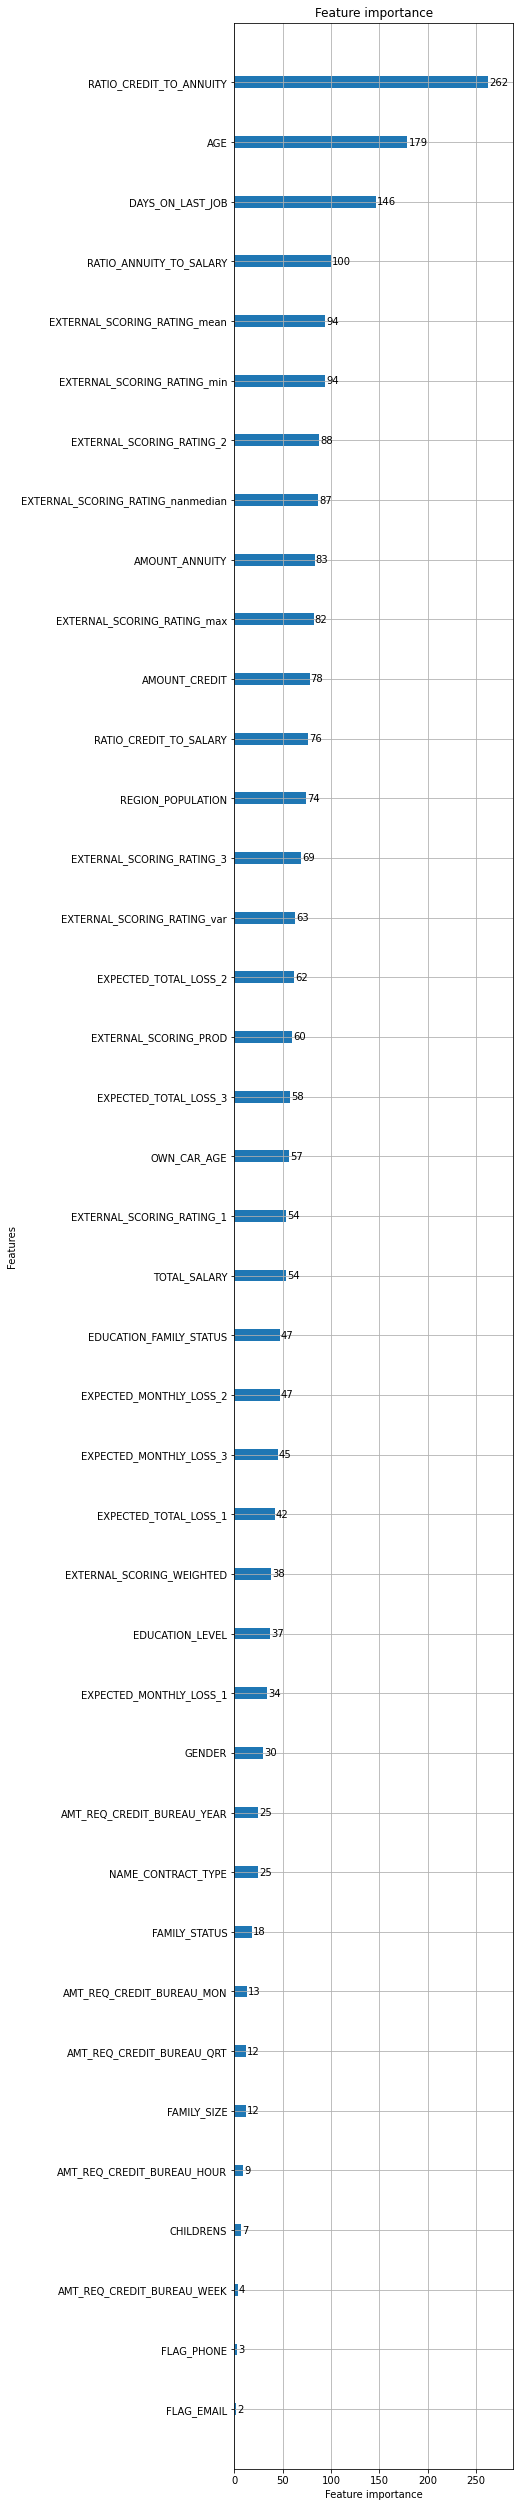

In [83]:
ax = lgbm.plot_importance(model, max_num_features=355, figsize=(5,45))   #, figsize=(45,5)
plt.show()

In [84]:
# keys = X_train.columns
# values = model.feature_importance()

# fi_dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
# fi_dt

In [85]:
feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X_train.columns})

In [86]:
f_imp = feature_imp.sort_values("Value", ascending=False).reset_index(drop=True)

In [87]:
# pd.set_option('display.max_rows', 20)

In [88]:
f_imp.loc[f_imp['Value'] > 0, 'Feature']

0               RATIO_CREDIT_TO_ANNUITY
1                                   AGE
2                      DAYS_ON_LAST_JOB
3               RATIO_ANNUITY_TO_SALARY
4          EXTERNAL_SCORING_RATING_mean
5           EXTERNAL_SCORING_RATING_min
6             EXTERNAL_SCORING_RATING_2
7     EXTERNAL_SCORING_RATING_nanmedian
8                        AMOUNT_ANNUITY
9           EXTERNAL_SCORING_RATING_max
10                        AMOUNT_CREDIT
11               RATIO_CREDIT_TO_SALARY
12                    REGION_POPULATION
13            EXTERNAL_SCORING_RATING_3
14          EXTERNAL_SCORING_RATING_var
15                EXPECTED_TOTAL_LOSS_2
16                EXTERNAL_SCORING_PROD
17                EXPECTED_TOTAL_LOSS_3
18                          OWN_CAR_AGE
19            EXTERNAL_SCORING_RATING_1
20                         TOTAL_SALARY
21              EXPECTED_MONTHLY_LOSS_2
22              EDUCATION_FAMILY_STATUS
23              EXPECTED_MONTHLY_LOSS_3
24                EXPECTED_TOTAL_LOSS_1


In [89]:
col_list = f_imp.loc[f_imp['Value'] > 0, 'Feature'].values

In [90]:
train_crop = train_prep[col_list]

In [91]:
train_cat_crop = train_cat_prep[col_list]

In [92]:
test_crop = test_prep[col_list]

In [93]:
test_cat_crop = test_cat_prep[col_list]

In [94]:
train_cat_crop.head(3)

,RATIO_CREDIT_TO_ANNUITY,AGE,DAYS_ON_LAST_JOB,RATIO_ANNUITY_TO_SALARY,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_nanmedian,AMOUNT_ANNUITY,EXTERNAL_SCORING_RATING_max,AMOUNT_CREDIT,RATIO_CREDIT_TO_SALARY,REGION_POPULATION,EXTERNAL_SCORING_RATING_3,EXTERNAL_SCORING_RATING_var,EXPECTED_TOTAL_LOSS_2,EXTERNAL_SCORING_PROD,EXPECTED_TOTAL_LOSS_3,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,TOTAL_SALARY,EXPECTED_MONTHLY_LOSS_2,EDUCATION_FAMILY_STATUS,EXPECTED_MONTHLY_LOSS_3,EXPECTED_TOTAL_LOSS_1,EXTERNAL_SCORING_WEIGHTED,EDUCATION_LEVEL,EXPECTED_MONTHLY_LOSS_1,GENDER,NAME_CONTRACT_TYPE,AMT_REQ_CREDIT_BUREAU_YEAR,FAMILY_STATUS,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,FAMILY_SIZE,AMT_REQ_CREDIT_BUREAU_HOUR,CHILDRENS,AMT_REQ_CREDIT_BUREAU_WEEK,FLAG_PHONE,FLAG_EMAIL
0,34.025788,15728.0,1719.0,0.159543,0.687756,0.645914,0.645914,0.700784,25128.0,0.716570,855000.0,5.428571,0.019101,0.716570,0.000917,552256.266546,0.324353,612667.559305,11.0,0.700784,157500.0,16230.521013,Secondary / secondary special | Married,18005.977111,599170.547652,4.197193,Secondary / secondary special,17609.307043,M,Cash,2.0,Married,0.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0
1,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,No | No,-1.000000,-1.000000,-1.000000,No,-1.000000,No,Cash,-1.0,No,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,23.603376,21557.0,3618.0,0.316000,0.475009,0.267869,0.682149,0.475009,42660.0,0.682149,1006920.0,7.458667,0.026392,0.267869,0.042907,686869.876357,-1.000000,269722.588880,-1.0,-1.000000,135000.0,29100.493510,Higher education | Married,11427.288803,-1.000000,-1.000000,Higher education,-1.000000,F,Cash,4.0,Married,7.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0


In [95]:
# train_crop.to_csv(data_dir + "train_crop.csv", sep=";", index=False)
# train_cat_crop.to_csv(data_dir + "train_cat_crop.csv", sep=";", index=False)
# test_crop.to_csv(data_dir + "test_crop.csv", sep=";", index=False)
# test_cat_crop.to_csv(data_dir + "test_cat_crop.csv", sep=";", index=False)

### Пермутированная важность (permutation importance)

In [96]:
def calculate_permutation_importance(estimator, 
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.Series) -> pd.Series:
    """
    Расчет пермутированной важности признаков.
    """
    scores = {}
    y_pred = estimator.predict(x_valid)
    base_score = metric(y_valid, y_pred)

    for feature in tqdm(x_valid.columns):
        x_valid_copy = x_valid.copy()
        x_valid_copy[feature] = np.random.permutation(x_valid_copy[feature])

        y_pred = estimator.predict(x_valid_copy)
        score = metric(y_valid, y_pred)
        scores[feature] = base_score - score

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores

In [97]:
X_train, X_valid, y_train, y_valid = train_test_split(train_prep.drop(["APPLICATION_NUMBER", "TARGET"], axis=1), 
                                                      train_prep["TARGET"], 
                                                      test_size=0.2, 
                                                      random_state=42)

train_data = lgbm.Dataset(X_train, label=y_train)
test_data = lgbm.Dataset(X_valid, label=y_valid)

model = lgbm.train(lgbm_params,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=50,
                   verbose_eval=False)

In [98]:
perm_importance = calculate_permutation_importance(
    estimator=model, metric=roc_auc_score, x_valid=X_valid, y_valid=y_valid
)

100%|██████████| 41/41 [00:02<00:00, 16.70it/s]


In [99]:
perm_importance

EXTERNAL_SCORING_RATING_mean         0.076518
RATIO_CREDIT_TO_ANNUITY              0.018427
AGE                                  0.014113
EDUCATION_LEVEL                      0.013856
EXPECTED_MONTHLY_LOSS_3              0.009722
DAYS_ON_LAST_JOB                     0.008636
EXTERNAL_SCORING_RATING_min          0.006543
AMOUNT_ANNUITY                       0.006541
EXTERNAL_SCORING_RATING_3            0.006079
NAME_CONTRACT_TYPE                   0.005765
EXTERNAL_SCORING_RATING_2            0.003577
GENDER                               0.003556
EXTERNAL_SCORING_PROD                0.003385
EXPECTED_TOTAL_LOSS_2                0.002763
AMOUNT_CREDIT                        0.002728
OWN_CAR_AGE                          0.002661
EXTERNAL_SCORING_WEIGHTED            0.002626
TOTAL_SALARY                         0.002619
EDUCATION_FAMILY_STATUS              0.002603
EXTERNAL_SCORING_RATING_nanmedian    0.002367
EXPECTED_MONTHLY_LOSS_2              0.002100
EXTERNAL_SCORING_RATING_1         

In [100]:
col_list_2 = perm_importance[perm_importance > 0.0001].index

In [101]:
col_list_2

Index(['EXTERNAL_SCORING_RATING_mean', 'RATIO_CREDIT_TO_ANNUITY', 'AGE',
       'EDUCATION_LEVEL', 'EXPECTED_MONTHLY_LOSS_3', 'DAYS_ON_LAST_JOB',
       'EXTERNAL_SCORING_RATING_min', 'AMOUNT_ANNUITY',
       'EXTERNAL_SCORING_RATING_3', 'NAME_CONTRACT_TYPE',
       'EXTERNAL_SCORING_RATING_2', 'GENDER', 'EXTERNAL_SCORING_PROD',
       'EXPECTED_TOTAL_LOSS_2', 'AMOUNT_CREDIT', 'OWN_CAR_AGE',
       'EXTERNAL_SCORING_WEIGHTED', 'TOTAL_SALARY', 'EDUCATION_FAMILY_STATUS',
       'EXTERNAL_SCORING_RATING_nanmedian', 'EXPECTED_MONTHLY_LOSS_2',
       'EXTERNAL_SCORING_RATING_1', 'REGION_POPULATION',
       'RATIO_CREDIT_TO_SALARY', 'EXPECTED_TOTAL_LOSS_3',
       'EXTERNAL_SCORING_RATING_max', 'EXPECTED_TOTAL_LOSS_1',
       'RATIO_ANNUITY_TO_SALARY', 'FAMILY_STATUS',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'EXTERNAL_SCORING_RATING_var'],
      dtype='object')

In [102]:
train_crop_2 = train_prep[col_list_2]

In [103]:
train_cat_crop_2 = train_cat_prep[col_list_2]

In [104]:
test_crop_2 = test_prep[col_list_2]

In [105]:
test_cat_crop_2 = test_cat_prep[col_list_2]

In [106]:
test_cat_crop_2.head(3)

,EXTERNAL_SCORING_RATING_mean,RATIO_CREDIT_TO_ANNUITY,AGE,EDUCATION_LEVEL,EXPECTED_MONTHLY_LOSS_3,DAYS_ON_LAST_JOB,EXTERNAL_SCORING_RATING_min,AMOUNT_ANNUITY,EXTERNAL_SCORING_RATING_3,NAME_CONTRACT_TYPE,EXTERNAL_SCORING_RATING_2,GENDER,EXTERNAL_SCORING_PROD,EXPECTED_TOTAL_LOSS_2,AMOUNT_CREDIT,OWN_CAR_AGE,EXTERNAL_SCORING_WEIGHTED,TOTAL_SALARY,EDUCATION_FAMILY_STATUS,EXTERNAL_SCORING_RATING_nanmedian,EXPECTED_MONTHLY_LOSS_2,EXTERNAL_SCORING_RATING_1,REGION_POPULATION,RATIO_CREDIT_TO_SALARY,EXPECTED_TOTAL_LOSS_3,EXTERNAL_SCORING_RATING_max,EXPECTED_TOTAL_LOSS_1,RATIO_ANNUITY_TO_SALARY,FAMILY_STATUS,AMT_REQ_CREDIT_BUREAU_YEAR,EXTERNAL_SCORING_RATING_var
0,0.628266,34.199726,16007.0,Secondary / secondary special,-1.000000,2646.0,0.628266,32895.0,-1.000000,Cash,0.628266,M,-1.0,706799.427892,1125000.0,20.0,-1.0,117000.0,Secondary / secondary special | Married,0.628266,20666.815272,-1.0,0.028663,9.615385,-1.000000,0.628266,-1.0,0.281154,Married,4.0,0.000000
1,0.383325,18.295341,10315.0,Secondary / secondary special,3222.322825,459.0,0.188490,17095.5,0.188490,Cash,0.578161,F,-1.0,180830.265914,312768.0,-1.0,-1.0,81000.0,Secondary / secondary special | Married,0.383325,9883.951718,-1.0,0.019689,3.861333,58953.494506,0.578161,-1.0,0.211056,Married,2.0,0.037961
2,0.267523,20.000000,13016.0,Secondary / secondary special,8606.290593,977.0,0.152544,22500.0,0.382502,Credit Card,0.152544,F,-1.0,68644.984320,450000.0,-1.0,-1.0,157500.0,Secondary / secondary special | Married,0.267523,3432.249216,-1.0,0.019101,2.857143,172125.811865,0.382502,-1.0,0.142857,Married,6.0,0.013220


In [107]:
# train_crop_2.to_csv(data_dir + "train_crop_2.csv", sep=";", index=False)
# train_cat_crop_2.to_csv(data_dir + "train_cat_crop_2.csv", sep=";", index=False)
# test_crop_2.to_csv(data_dir + "test_crop_2.csv", sep=";", index=False)
# test_cat_crop_2.to_csv(data_dir + "test_cat_crop_2.csv", sep=";", index=False)

### Подбор параметров на сокращённых наборах

In [108]:
def get_model_lgbm_reg_hp(parameters, X, y):
    clf = GridSearchCV(
        estimator=lgbm.LGBMClassifier(subsample=0.5, random_state=42),
        param_grid=parameters,
        scoring='roc_auc',
        cv=5,
        return_train_score = True
    )
    
    clf.fit(X, y)
    
    cv_results = pd.DataFrame(clf.cv_results_)

    #print(cv_results.columns)
    
    param_columns = [
        column
        for column in cv_results.columns
        if column.startswith('param_')
    ]

    score_columns = ['mean_test_score', 'mean_train_score']

    cv_results = (cv_results[param_columns + score_columns]
                  .sort_values(by=score_columns, ascending=False))

    print(cv_results)
    print(f"\nbest params: {clf.best_params_}\n")
    return clf

In [109]:
parameters_l_2 = {
    'num_leaves': [26, 31],
    # 'max_depth': [5], #, 3, 7
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.05]
}

In [110]:
# clf_l_c1 = get_model_lgbm_reg_hp(parameters_l_2, train_crop,  train_prep["TARGET"])

In [111]:
# clf_l_c2 = get_model_lgbm_reg_hp(parameters_l_2, train_crop_2,  train_prep["TARGET"])

In [112]:
cv_strategy = KFold(n_splits=5, random_state=42)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [113]:
# best params: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 26}
params_l_2_1 = {}
params_l_2_1["num_leaves"] = 26 # clf_l_c1.best_params_['num_leaves']
# params_l2["max_depth"] = clf_l_c1.best_params_['max_depth']
params_l_2_1["n_estimators"] = 100 # clf_l_c1.best_params_['n_estimators']
params_l_2_1["learning_rate"] = 0.05 # clf_l_c1.best_params_['learning_rate']

In [114]:
estimators_lgbm_c1, oof_score_lgbm_c1, fold_train_scores_lgbm_c1, fold_valid_scores_lgbm_c1, oof_predictions_lgbm_c1 = make_cross_validation_adapt_l(
    train_crop,
    train_prep["TARGET"],
    params=params_l_2_1,
    metric=roc_auc_score, 
    cv_strategy=cv_strategy
)

Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.7566, valid-score = 0.7205
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.7551, valid-score = 0.7191
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.7525, valid-score = 0.7283
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.7544, valid-score = 0.7231
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.7525, valid-score = 0.7296
CV-results train: 0.7542 +/- 0.002
CV-results valid: 0.7241 +/- 0.004
OOF-score = 0.7233


In [115]:
# best params: {'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 26}
params_l_2_2 = {}
params_l_2_2["num_leaves"] = 26 # clf_l_c2.best_params_['num_leaves']
# params_l2["max_depth"] = clf_l_c1.best_params_['max_depth']
params_l_2_2["n_estimators"] = 200 # clf_l_c2.best_params_['n_estimators']
params_l_2_2["learning_rate"] = 0.05 # clf_l_c2.best_params_['learning_rate']

In [116]:
estimators_lgbm_c2, oof_score_lgbm_c2, fold_train_scores_lgbm_c2, fold_valid_scores_lgbm_c2, oof_predictions_lgbm_c2 = make_cross_validation_adapt_l(
    train_crop_2,
    train_prep["TARGET"],
    params=params_l_2_2,
    metric=roc_auc_score, 
    cv_strategy=cv_strategy
)

Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.7774, valid-score = 0.7223
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.7689, valid-score = 0.7218
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.7812, valid-score = 0.731
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.7624, valid-score = 0.7223
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.7442, valid-score = 0.728
CV-results train: 0.7668 +/- 0.013
CV-results valid: 0.7251 +/- 0.004
OOF-score = 0.7242


In [117]:
# best params: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 26}
lgbm_params_2_1 =  {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    "num_leaves": 26, # clf_l_c1.best_params_['num_leaves'],
    "learning_rate": 0.05, # clf_l_c1.best_params_['learning_rate'],
    # "n_estimators": 100, # clf_l_c1.best_params_['n_estimators'],
    "random_state": 42 
    }

In [118]:
dftrainLGB = lgbm.Dataset(data = train_crop, 
                          label = train_prep["TARGET"])
                        #   feature_name = list(x_train))

cv_results_l_2_1 = lgbm.cv(
        lgbm_params_2_1,
        dftrainLGB,
        num_boost_round=2000,
        nfold=5,
        metrics='auc',
        early_stopping_rounds=50
        )

In [119]:
print(f"lgbm.cv auc-mean: {cv_results_l_2_1['auc-mean'][len(cv_results_l_2_1['auc-mean'])-1]:.4f}, \
auc-stdv: {cv_results_l_2_1['auc-stdv'][len(cv_results_l_2_1['auc-stdv'])-1]:.4f}")

lgbm.cv auc-mean: 0.7243, auc-stdv: 0.0064


In [120]:
# best params: {'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 26}
lgbm_params_2_2 =  {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    "num_leaves": 26, # clf_l_c2.best_params_['num_leaves'],
    "learning_rate": 0.05, # clf_l_c2.best_params_['learning_rate'],
    # "n_estimators": 200, # clf_l_c2.best_params_['n_estimators'],
    "random_state": 42 
    }

In [121]:
dftrainLGB = lgbm.Dataset(data = train_crop_2, 
                          label = train_prep["TARGET"])
                        #   feature_name = list(x_train))

cv_results_l_2_2 = lgbm.cv(
        lgbm_params_2_2,
        dftrainLGB,
        num_boost_round=2000,
        nfold=5,
        metrics='auc',
        early_stopping_rounds=50
        )

In [122]:
print(f"lgbm.cv auc-mean: {cv_results_l_2_2['auc-mean'][len(cv_results_l_2_2['auc-mean'])-1]:.4f}, \
auc-stdv: {cv_results_l_2_2['auc-stdv'][len(cv_results_l_2_2['auc-stdv'])-1]:.4f}")

lgbm.cv auc-mean: 0.7244, auc-stdv: 0.0064


In [123]:
oof_predictions_lgbm_f_copy = oof_predictions_lgbm_f.copy()
oof_predictions_lgbm_c1_copy = oof_predictions_lgbm_c1.copy()
oof_predictions_lgbm_c2_copy = oof_predictions_lgbm_c2.copy()

oof_predictions_lgbm_f_copy[oof_predictions_lgbm_f_copy < 0.01] = 0
oof_predictions_lgbm_f_copy[oof_predictions_lgbm_f_copy > 0.99] = 1

oof_predictions_lgbm_c1_copy[oof_predictions_lgbm_c1_copy < 0.03] = 0
oof_predictions_lgbm_c1_copy[oof_predictions_lgbm_c1_copy > 0.97] = 1

oof_predictions_lgbm_c2_copy[oof_predictions_lgbm_c2_copy < 0.05] = 0
oof_predictions_lgbm_c2_copy[oof_predictions_lgbm_c2_copy > 0.95] = 1

score_lgbm_f = roc_auc_score(train_prep["TARGET"].values, oof_predictions_lgbm_f)
score_lgbm_f_c = roc_auc_score(train_prep["TARGET"].values, oof_predictions_lgbm_f_copy)
print(f"oof_predictions_lgbm_f score: {round(score_lgbm_f, 4)} mod {round(score_lgbm_f_c, 4)}")

score_lgbm_c1 = roc_auc_score(train_prep["TARGET"].values, oof_predictions_lgbm_c1)
score_lgbm_c1_c = roc_auc_score(train_prep["TARGET"].values, oof_predictions_lgbm_c1_copy)
print(f"oof_predictions_lgbm_c1 score: {round(score_lgbm_c1, 4)} mod {round(score_lgbm_c1_c, 4)}")

score_lgbm_c2 = roc_auc_score(train_prep["TARGET"].values, oof_predictions_lgbm_c2)
score_lgbm_c2_c = roc_auc_score(train_prep["TARGET"].values, oof_predictions_lgbm_c2_copy)
print(f"oof_predictions_lgbm_c2 score: {round(score_lgbm_c2, 4)} mod {round(score_lgbm_c2_c, 4)}")

oof_predictions_lgbm_f score: 0.7239 mod 0.7239
oof_predictions_lgbm_c1 score: 0.7233 mod 0.7228
oof_predictions_lgbm_c2 score: 0.7242 mod 0.7175


### LightGBM данные для загрузки

In [124]:
prediction_lgbm_c2 = test[['APPLICATION_NUMBER']].copy()
prediction_lgbm_c2["TARGET"] = 0
prediction_lgbm_c2.head()

,APPLICATION_NUMBER,TARGET
0,123724268,0
1,123456549,0
2,123428178,0
3,123619984,0
4,123671104,0


In [125]:
test_predictions_lgbm_f = np.zeros(prediction_lgbm_c2["TARGET"].shape[0])
test_predictions_lgbm_c1 = np.zeros(prediction_lgbm_c2["TARGET"].shape[0])
test_predictions_lgbm_c2 = np.zeros(prediction_lgbm_c2["TARGET"].shape[0])

for i in range(5):
    test_predictions_lgbm_f += estimators_lgbm_f[i].predict(test_prep.drop(["APPLICATION_NUMBER"], axis=1))
    test_predictions_lgbm_c1 += estimators_lgbm_c1[i].predict(test_crop)
    test_predictions_lgbm_c2 += estimators_lgbm_c2[i].predict(test_crop_2)

test_predictions_lgbm_f /= 5
test_predictions_lgbm_c1 /= 5
test_predictions_lgbm_c2 /= 5

In [126]:
test_predictions_lgbm_f[test_predictions_lgbm_f < 0] = 0
test_predictions_lgbm_f[test_predictions_lgbm_f > 1] = 1

test_predictions_lgbm_c1[test_predictions_lgbm_c1 < 0] = 0
test_predictions_lgbm_c1[test_predictions_lgbm_c1 > 1] = 1

test_predictions_lgbm_c2[test_predictions_lgbm_c2 < 0] = 0
test_predictions_lgbm_c2[test_predictions_lgbm_c2 > 1] = 1

In [127]:
prediction_lgbm_c2["TARGET"] = test_predictions_lgbm_c2.copy()
prediction_lgbm_c2.tail()

,APPLICATION_NUMBER,TARGET
165136,123487967,0.083334
165137,123536402,0.037703
165138,123718238,0.083334
165139,123631557,0.022199
165140,123433260,0.052735


In [128]:
prediction_lgbm_c2.to_csv(working_dir + "prediction_lgbm_c2.csv", sep=",", index=False)

## XGBoost

In [129]:
def get_model_hp(parameters, X, y):
    clf = GridSearchCV(
        estimator=xgb.XGBClassifier(silent=False, subsample=0.5, random_state=42),
        param_grid=parameters,
        scoring='roc_auc',
        cv=5,
        return_train_score = True
    )
    
    clf.fit(X, y)
    
    cv_results = pd.DataFrame(clf.cv_results_)

    #print(cv_results.columns)
    
    param_columns = [
        column
        for column in cv_results.columns
        if column.startswith('param_')
    ]

    score_columns = ['mean_test_score', 'mean_train_score']

    cv_results = (cv_results[param_columns + score_columns]
                  .sort_values(by=score_columns, ascending=False))

    print(cv_results)
    print(f"\nbest params: {clf.best_params_}\n")
    return clf

In [130]:
parameters = {
    'max_depth': [4, 6, 8],
    'eta': [0.3, 0.05]
    }

In [131]:
# clf_1 = get_model_hp(parameters, train_crop,  train_prep["TARGET"])

In [132]:
# clf_2 = get_model_hp(parameters, train_crop_2,  train_prep["TARGET"])

In [133]:
def make_cross_validation_adapt(X: pd.DataFrame,
                                y: pd.Series,
                                params: Dict,
                                metric: callable,
                                cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    params: Dict
        Параметры модели.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

#     plst = list(params.items())

    num_rounds=1000 
    
    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        xgtrain = xgb.DMatrix(x_train, label=y_train)
        xgval = xgb.DMatrix(x_valid, label=y_valid)

        watchlist = [(xgtrain,'train'), (xgval,'eval')]

        model = xgb.train(params, #plst, 
                          xgtrain, 
                          num_rounds,
                          watchlist,
                          verbose_eval=False,
                          early_stopping_rounds=10)

        y_train_pred = model.predict(xgtrain)
        y_valid_pred = model.predict(xgval)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(model)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [134]:
# best params: {'eta': 0.3, 'max_depth': 4}
params = {}
params["objective"] = "binary:logistic"
params["eta"] = 0.3 # clf_1.best_params_['eta']
# params["n_estimators"] = clf.best_params_['n_estimators']
params["random_state"] = 42
params["max_depth"] = 4 # clf_1.best_params_['max_depth']
params["eval_metric"] = "auc"

In [135]:
cv_strategy = KFold(n_splits=5, random_state=42)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [136]:
estimators_xgb_c1, oof_score_xgb_c1, fold_train_scores_xgb_c1, fold_valid_scores_xgb_c1, oof_predictions_xgb_c1 = make_cross_validation_adapt(
    train_crop,
    train_prep["TARGET"],
    params=params,
    metric=roc_auc_score, 
    cv_strategy=cv_strategy
)

Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.7752, valid-score = 0.7239
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.779, valid-score = 0.716
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.7592, valid-score = 0.7254
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.7645, valid-score = 0.7218
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.7677, valid-score = 0.7297
CV-results train: 0.7691 +/- 0.007
CV-results valid: 0.7234 +/- 0.005
OOF-score = 0.7226


In [137]:
estimators_xgb_c2, oof_score_xgb_c2, fold_train_scores_xgb_c2, fold_valid_scores_xgb_c2, oof_predictions_xgb_c2 = make_cross_validation_adapt(
    train_crop_2,
    train_prep["TARGET"],
    params=params,
    metric=roc_auc_score, 
    cv_strategy=cv_strategy
)

Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.7686, valid-score = 0.7238
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.7804, valid-score = 0.7164
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.7798, valid-score = 0.7277
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.7988, valid-score = 0.7237
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.7859, valid-score = 0.7305
CV-results train: 0.7827 +/- 0.01
CV-results valid: 0.7244 +/- 0.005
OOF-score = 0.7236


In [138]:
params2 = {}
params2["objective"] = "binary:logistic"
params2["eta"] = 0.05 # clf_1.best_params_['eta']
# params["n_estimators"] = clf.best_params_['n_estimators']
params2["random_state"] = 42
params2["max_depth"] = 4 # clf_1.best_params_['max_depth']
params2["eval_metric"] = "auc"

In [139]:
def make_cross_validation_adapt2(X: pd.DataFrame,
                                y: pd.Series,
                                params: Dict,
                                metric: callable,
                                cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    params: Dict
        Параметры модели.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    plst = list(params.items())

    num_rounds=10000 
    
    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        xgtrain = xgb.DMatrix(x_train, label=y_train)
        xgval = xgb.DMatrix(x_valid, label=y_valid)

        watchlist = [(xgtrain,'train'), (xgval,'eval')]

        model = xgb.train(plst, 
                          xgtrain, 
                          num_rounds,
                          watchlist,
                          verbose_eval=False,
                          early_stopping_rounds=50)

        y_train_pred = model.predict(xgtrain)
        y_valid_pred = model.predict(xgval)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(model)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [140]:
estimators_xgb2_c2, oof_score_xgb2_c2, fold_train_scores_xgb2_c2, fold_valid_scores_xgb2_c2, oof_predictions_xgb2_c2 = make_cross_validation_adapt2(
    train_crop_2,
    train_prep["TARGET"],
    params=params2,
    metric=roc_auc_score, 
    cv_strategy=cv_strategy
)

Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.7748, valid-score = 0.7263
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.7852, valid-score = 0.7211
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.7817, valid-score = 0.7307
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.7923, valid-score = 0.7293
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.7759, valid-score = 0.7342
CV-results train: 0.782 +/- 0.006
CV-results valid: 0.7283 +/- 0.004
OOF-score = 0.7275


In [141]:
oof_predictions_xgb2_c2_score = roc_auc_score(train_prep["TARGET"].values, oof_predictions_xgb2_c2)
print(f"oof_predictions_xgb2_c2 score: {round(oof_predictions_xgb2_c2_score, 4)}")

oof_predictions_xgb2_c2 score: 0.7275


In [142]:
cv_results_1 = xgb.cv(dtrain=xgb.DMatrix(train_crop, label=train_prep["TARGET"]), 
                      params=params, 
                      nfold=5,
                      num_boost_round=1000,
                      early_stopping_rounds=50,
                      metrics="auc", 
                      as_pandas=True, 
                      seed=42)

In [143]:
cv_results_2 = xgb.cv(dtrain=xgb.DMatrix(train_crop_2, label=train_prep["TARGET"]), 
                      params=params, 
                      nfold=5,
                      num_boost_round=1000,
                      early_stopping_rounds=50,
                      metrics="auc", 
                      as_pandas=True, 
                      seed=42)

In [144]:

cv_results_3 = xgb.cv(dtrain=xgb.DMatrix(train_crop_2, label=train_prep["TARGET"]), 
                      params=params2, 
                      nfold=5,
                      num_boost_round=10000,
                      early_stopping_rounds=50,
                      metrics="auc", 
                      as_pandas=True, 
                      seed=42)

In [145]:
# cv_results_1.head()

In [146]:
# cv_results_2.head()

In [147]:
print((cv_results_1["test-auc-mean"]).tail(1))

44    0.727117
Name: test-auc-mean, dtype: float64


In [148]:
print((cv_results_2["test-auc-mean"]).tail(1))

42    0.726041
Name: test-auc-mean, dtype: float64


In [149]:
print((cv_results_3["test-auc-mean"]).tail(1))

397    0.729998
Name: test-auc-mean, dtype: float64



### Обучение XGBoost с последовательным добавлением характеристик из perm_importance

In [150]:
def feature_sort(feat_list: pd.Series, params: Dict, fn1=True)->List: #pd.Series, List, List, List, List, List:
    perm_imp = feat_list.copy()
    print(f"Характеристики до: \n{perm_imp}\n")
#     print("\n")
    
    estimators = []
    oof_score = []
    fold_train_scores = []
    fold_valid_scores = []
    oof_predictions = []
    
    for j in range(2):
        estimators.clear()
        oof_score.clear()
        fold_train_scores.clear()
        fold_valid_scores.clear()
        oof_predictions.clear()

        for i in range(len(perm_imp)):
            print(f"{i+1} Новый параметр {perm_imp.index[i]}\n")
            if fn1:
                estimators_tmp, oof_score_tmp, fold_train_scores_tmp, fold_valid_scores_tmp, oof_predictions_tmp = make_cross_validation_adapt(
                        train_prep[perm_imp.index[:i+1]],
                        train_prep["TARGET"],
                        params=params,
                        metric=roc_auc_score, 
                        cv_strategy=cv_strategy
                    )
            else:
                estimators_tmp, oof_score_tmp, fold_train_scores_tmp, fold_valid_scores_tmp, oof_predictions_tmp = make_cross_validation_adapt2(
                        train_prep[perm_imp.index[:i+1]],
                        train_prep["TARGET"],
                        params=params,
                        metric=roc_auc_score, 
                        cv_strategy=cv_strategy
                    )
            estimators.append(estimators_tmp)
            oof_score.append(oof_score_tmp)
            fold_train_scores.append(fold_train_scores_tmp)
            fold_valid_scores.append(fold_valid_scores_tmp)
            oof_predictions.append(oof_predictions_tmp)
        #     score = roc_auc_score(train_prep["TARGET"].values, oof_predictions_tmp)
        #     print(f"{i+1} Новый параметр {perm_importance.index[i]} score: {round(score, 4)}")
            print("\n")
        
        plt.plot(oof_score)
        plt.show()
        lst = [oof_score[0]]
        lst.extend(list(np.array(oof_score[1:]) - np.array(oof_score[:-1])))
        perm_imp_prev = perm_imp.copy()
        perm_imp = pd.Series(lst, index=perm_imp_prev.index)
        perm_imp.sort_values(ascending=False, inplace=True)
        print(f"Характеристики после:\n{perm_imp}\n")
#         print("\n")
    
    return perm_imp, perm_imp_prev, estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [151]:
# feat_lst, feat_lst_prev, estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = feature_sort(perm_importance, params)

In [152]:
# feat_lst2, feat_lst_prev2, estimators2, oof_score2, fold_train_scores2, fold_valid_scores2, oof_predictions2 = feature_sort(perm_importance, params2, False)

In [153]:
# train_crop_3 = train_prep[feat_lst[:30]].copy()
# train_crop_3.head()

# test_crop_3 = test_prep[feat_lst[:30]].copy()
# test_crop_3.head()

In [154]:
# train_crop_4 = train_prep[perm_importance.index[:31]].copy()
# train_crop_4.head(2)

# test_crop_4 = test_prep[perm_importance.index[:31]].copy()
# test_crop_4.head(2)

### Обучение XGBoost на отобранных признаках

In [155]:
# estimators_xgb_c3, oof_score_xgb_c3, fold_train_scores_xgb_c3, fold_valid_scores_xgb_c3, oof_predictions_xgb_c3 = make_cross_validation_adapt2(
#     train_crop_3,
#     train_prep["TARGET"],
#     params=params2,
#     metric=roc_auc_score, 
#     cv_strategy=cv_strategy
# )

In [156]:
# estimators_xgb_c4, oof_score_xgb_c4, fold_train_scores_xgb_c4, fold_valid_scores_xgb_c4, oof_predictions_xgb_c4 = make_cross_validation_adapt2(
#     train_crop_4,
#     train_prep["TARGET"],
#     params=params2,
#     metric=roc_auc_score, 
#     cv_strategy=cv_strategy
# )

### XGBoost данные для загрузки

In [157]:
prediction_xgb_c1 = test[['APPLICATION_NUMBER']].copy()
prediction_xgb_c1["TARGET"] = 0
prediction_xgb_c1.head()

prediction_xgb_c2 = test[['APPLICATION_NUMBER']].copy()
prediction_xgb_c2["TARGET"] = 0
prediction_xgb_c2.head()

prediction_xgb2_c2 = test[['APPLICATION_NUMBER']].copy()
prediction_xgb2_c2["TARGET"] = 0
prediction_xgb2_c2.head()

# prediction_xgb_c3 = test[['APPLICATION_NUMBER']].copy()
# prediction_xgb_c3["TARGET"] = 0
# prediction_xgb_c3.head()

# prediction_xgb_c4 = test[['APPLICATION_NUMBER']].copy()
# prediction_xgb_c4["TARGET"] = 0
# prediction_xgb_c4.head()

,APPLICATION_NUMBER,TARGET
0,123724268,0
1,123456549,0
2,123428178,0
3,123619984,0
4,123671104,0


In [158]:
test_predictions_xgb_c1 = np.zeros(test[['APPLICATION_NUMBER']].shape[0])
test_predictions_xgb_c2 = np.zeros(test[['APPLICATION_NUMBER']].shape[0])
test_predictions_xgb2_c2 = np.zeros(test[['APPLICATION_NUMBER']].shape[0])
# test_predictions_xgb_c3 = np.zeros(test[['APPLICATION_NUMBER']].shape[0])
# test_predictions_xgb_c4 = np.zeros(test[['APPLICATION_NUMBER']].shape[0])

for i in range(5):
    test_predictions_xgb_c1 += estimators_xgb_c1[i].predict(xgb.DMatrix(test_crop))
    test_predictions_xgb_c2 += estimators_xgb_c2[i].predict(xgb.DMatrix(test_crop_2))
    test_predictions_xgb2_c2 += estimators_xgb2_c2[i].predict(xgb.DMatrix(test_crop_2))
#     test_predictions_xgb_c3 += estimators_xgb_c3[i].predict(xgb.DMatrix(test_crop_3))
#     test_predictions_xgb_c4 += estimators_xgb_c4[i].predict(xgb.DMatrix(test_crop_4))

test_predictions_xgb_c1 /= 5
test_predictions_xgb_c2 /= 5
test_predictions_xgb2_c2 /= 5
# test_predictions_xgb_c3 /= 5
# test_predictions_xgb_c4 /= 5

test_predictions_xgb_c1[test_predictions_xgb_c1 < 0] = 0
test_predictions_xgb_c1[test_predictions_xgb_c1 > 1] = 1

test_predictions_xgb_c2[test_predictions_xgb_c2 < 0] = 0
test_predictions_xgb_c2[test_predictions_xgb_c2 > 1] = 1

test_predictions_xgb2_c2[test_predictions_xgb2_c2 < 0] = 0
test_predictions_xgb2_c2[test_predictions_xgb2_c2 > 1] = 1

# test_predictions_xgb_c3[test_predictions_xgb_c3 < 0] = 0
# test_predictions_xgb_c3[test_predictions_xgb_c3 > 1] = 1

# test_predictions_xgb_c4[test_predictions_xgb_c4 < 0] = 0
# test_predictions_xgb_c4[test_predictions_xgb_c4 > 1] = 1

In [159]:
prediction_xgb_c1["TARGET"] = test_predictions_xgb_c1.copy()
prediction_xgb_c1.tail()

prediction_xgb_c2["TARGET"] = test_predictions_xgb_c2.copy()
prediction_xgb_c2.tail()

prediction_xgb2_c2["TARGET"] = test_predictions_xgb2_c2.copy()
prediction_xgb2_c2.tail()

# prediction_xgb_c3["TARGET"] = test_predictions_xgb_c3.copy()
# prediction_xgb_c3.tail()

# prediction_xgb_c4["TARGET"] = test_predictions_xgb_c4.copy()
# prediction_xgb_c4.tail()

,APPLICATION_NUMBER,TARGET
165136,123487967,0.084323
165137,123536402,0.038977
165138,123718238,0.084323
165139,123631557,0.012140
165140,123433260,0.044129


In [160]:
prediction_xgb_c1.to_csv(working_dir + "prediction_xgb_c1.csv", sep=",", index=False)
prediction_xgb_c2.to_csv(working_dir + "prediction_xgb_c2.csv", sep=",", index=False)
prediction_xgb2_c2.to_csv(working_dir + "prediction_xgb2_c2.csv", sep=",", index=False)
# prediction_xgb_c3.to_csv(working_dir + "prediction_xgb_c3.csv", sep=",", index=False)
# prediction_xgb_c4.to_csv(working_dir + "prediction_xgb_c4.csv", sep=",", index=False)

## CatBoost

In [161]:
import time

def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = catb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)],
            verbose_eval=False
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [162]:
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

cv = KFold(n_splits=5, random_state=42, shuffle=True)

In [163]:
train_cat = train_cat_prep.drop(["APPLICATION_NUMBER", "TARGET"], axis=1)
categorial = train_cat.dtypes[train_cat.dtypes == "object"].index
estimators_catb_f, oof_preds_catb_f = catboost_cross_validation(
        params=cb_params, 
        X=train_cat, 
        y=train_prep["TARGET"], 
        cv=cv, 
        categorical=categorial
)

Sun Oct  4 17:57:34 2020, Cross-Validation, 110093 rows, 41 cols
Fold 1, Valid score = 0.74023
Fold 2, Valid score = 0.71905
Fold 3, Valid score = 0.72627
Fold 4, Valid score = 0.72749
Fold 5, Valid score = 0.7126
Score by each fold: [0.74023, 0.71905, 0.72627, 0.72749, 0.7126]


In [164]:
score = roc_auc_score(train_prep["TARGET"].values, oof_preds_catb_f)
print(f"OOF-score = {score:.4f}")

OOF-score = 0.7243


In [165]:
categorial = train_cat_crop.dtypes[train_cat_crop.dtypes == "object"].index
estimators_catb_c1, oof_preds_catb_c1 = catboost_cross_validation(
        params=cb_params, 
        X=train_cat_crop, 
        y=train_prep["TARGET"], 
        cv=cv, 
        categorical=categorial
)

Sun Oct  4 18:06:53 2020, Cross-Validation, 110093 rows, 40 cols


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Fold 1, Valid score = 0.74029
Fold 2, Valid score = 0.71886
Fold 3, Valid score = 0.72579
Fold 4, Valid score = 0.72742
Fold 5, Valid score = 0.71059
Score by each fold: [0.74029, 0.71886, 0.72579, 0.72742, 0.71059]


In [166]:
score = roc_auc_score(train_prep["TARGET"].values, oof_preds_catb_c1)
print(f"OOF-score = {score:.4f}")

OOF-score = 0.7237


In [167]:
categorial = train_cat_crop_2.dtypes[train_cat_crop_2.dtypes == "object"].index
estimators_catb_c2, oof_preds_catb_c2 = catboost_cross_validation(
        params=cb_params, 
        X=train_cat_crop_2, 
        y=train_prep["TARGET"], 
        cv=cv, 
        categorical=categorial
)

Sun Oct  4 18:15:19 2020, Cross-Validation, 110093 rows, 31 cols


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Fold 1, Valid score = 0.7405
Fold 2, Valid score = 0.71914
Fold 3, Valid score = 0.72745
Fold 4, Valid score = 0.72889
Fold 5, Valid score = 0.7111
Score by each fold: [0.7405, 0.71914, 0.72745, 0.72889, 0.7111]


In [168]:
score = roc_auc_score(train_prep["TARGET"].values, oof_preds_catb_c2)
print(f"OOF-score = {score:.4f}")

OOF-score = 0.7246


### CatBoost данные для загрузки

In [169]:
prediction_cat_f = test[['APPLICATION_NUMBER']].copy()
prediction_cat_f["TARGET"] = 0
prediction_cat_f.head()

prediction_cat_c1 = test[['APPLICATION_NUMBER']].copy()
prediction_cat_c1["TARGET"] = 0
prediction_cat_c1.head()

prediction_cat_c2 = test[['APPLICATION_NUMBER']].copy()
prediction_cat_c2["TARGET"] = 0
prediction_cat_c2.head()

,APPLICATION_NUMBER,TARGET
0,123724268,0
1,123456549,0
2,123428178,0
3,123619984,0
4,123671104,0


In [170]:
test_preds_catb_f = np.zeros(prediction_cat_c2["TARGET"].shape[0])
test_preds_catb_c1 = np.zeros(prediction_cat_c2["TARGET"].shape[0])
test_preds_catb_c2 = np.zeros(prediction_cat_c2["TARGET"].shape[0])

for i in range(5):
    test_preds_catb_f += estimators_catb_f[i].predict_proba(test_prep.drop(["APPLICATION_NUMBER"], axis=1))[:, 1]
    test_preds_catb_c1 += estimators_catb_c1[i].predict_proba(test_cat_crop)[:, 1]
    test_preds_catb_c2 += estimators_catb_c2[i].predict_proba(test_cat_crop_2)[:, 1]

test_preds_catb_f /= 5
test_preds_catb_c1 /= 5
test_preds_catb_c2 /= 5

test_preds_catb_f[test_preds_catb_f < 0] = 0
test_preds_catb_f[test_preds_catb_f > 1] = 1

test_preds_catb_c1[test_preds_catb_c1 < 0] = 0
test_preds_catb_c1[test_preds_catb_c1 > 1] = 1

test_preds_catb_c2[test_preds_catb_c2 < 0] = 0
test_preds_catb_c2[test_preds_catb_c2 > 1] = 1

In [171]:
prediction_cat_f["TARGET"] = test_preds_catb_f.copy()
prediction_cat_f.tail()

prediction_cat_c1["TARGET"] = test_preds_catb_c1.copy()
prediction_cat_c1.tail()

prediction_cat_c2["TARGET"] = test_preds_catb_c2.copy()
prediction_cat_c2.tail()

,APPLICATION_NUMBER,TARGET
165136,123487967,0.084458
165137,123536402,0.047148
165138,123718238,0.084458
165139,123631557,0.021638
165140,123433260,0.050954


In [172]:
prediction_cat_f.to_csv(working_dir + "prediction_cat_f.csv", sep=",", index=False)
prediction_cat_c1.to_csv(working_dir + "prediction_cat_c1.csv", sep=",", index=False)
prediction_cat_c2.to_csv(working_dir + "prediction_cat_c2.csv", sep=",", index=False)

## Support Vector Machine

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [174]:
# X = train_prep.drop(["APPLICATION_NUMBER", "TARGET"], axis=1)
X = train_crop_2
X_train, X_valid, y_train, y_valid = train_test_split(X, train_prep["TARGET"].values, test_size=0.2, random_state=42)

In [175]:
y_train = y_train.astype(int)
y_valid = y_valid.astype(int)
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [176]:
scaler = StandardScaler()

scaler.fit_transform(X)
X_sc = pd.DataFrame(scaler.transform(X), columns=X.columns)
X_train_sc = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_valid_sc = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)

In [177]:
# tst = test_prep.drop(["APPLICATION_NUMBER"], axis=1)
# tst = scaler.transform(test_crop_2)
# np.isfinite(tst).all()
# np.isfinite(X).all()
X_test_sc = pd.DataFrame(scaler.transform(test_crop_2), columns=test_crop_2.columns)

In [178]:
# clf = SVC(gamma="auto", random_state=42)

# clf.fit(X_train_sc, y_train)

# y_pred = clf.predict(X_valid_sc)
# y_pred_train = clf.predict(X_train_sc)

In [179]:
# score_t = roc_auc_score(y_train, y_pred_train)
# print(f"AUC on train = {score_t:.4f}")
# score_v = roc_auc_score(y_valid, y_pred)
# print(f"AUC on valid = {score_v:.4f}")

## KNN

In [180]:
scaler_mm = StandardScaler() # MinMaxScaler()  #RobustScaler()  

scaler_mm.fit_transform(X)
X_train_sc = pd.DataFrame(scaler_mm.transform(X_train), columns=X_train.columns)
X_valid_sc = pd.DataFrame(scaler_mm.transform(X_valid), columns=X_valid.columns)

In [181]:
k_values = np.arange(1, 5)

auc_on_train = []
auc_on_valid = []

# for i, value in enumerate(k_values):
#     clf = KNeighborsClassifier(n_neighbors=value)
    
#     clf.fit(X_train_sc, y_train)
    
#     y_pred = clf.predict(X_valid_sc)
#     y_pred_train = clf.predict(X_train_sc)
        
#     auc_valid = roc_auc_score(y_valid, y_pred)
#     auc_train = roc_auc_score(y_train, y_pred_train)
    
#     #if i% 2 == 0: 
#     print('K = {}'.format(value))
#     print('\tacc_train = {}'.format(auc_train))
#     print('\tacc_valid = {}\n'.format(auc_valid))
    
#     auc_on_train.append(auc_train)
#     auc_on_valid.append(auc_valid)

In [182]:
# plt.plot(k_values, auc_on_valid, label="valid")
# plt.plot(k_values, auc_on_train, label="train")

# plt.xlabel('K')
# plt.ylabel('AUC')

# plt.legend()
# plt.grid()

# plt.show()

In [183]:
# clf = KNeighborsClassifier(n_neighbors=3)

# clf.fit(X_train_sc, y_train)

# y_pred = clf.predict(X_valid_sc)

# score = roc_auc_score(y_valid, y_pred)
# print(f"Score = {score:.4f}")

## Random Forest

In [184]:
# clf = RandomForestClassifier(max_depth=15, max_features=15, n_estimators=2000, random_state=42)

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_valid)

# score = roc_auc_score(y_valid, y_pred)
# print(f"Score = {score:.4f}")

## Полносвязная нейросеть

In [185]:
import tensorflow as tf

# !pip install -q tensorflow-hub
# !pip install -q tensorflow-datasets
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import keras

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from keras.utils import to_categorical

In [186]:
def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [187]:
train_data = X_train_sc.values
validation_data = X_valid_sc.values
train_data.shape

(88074, 31)

In [188]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [189]:
def net_gen(func='relu', lay_cnt=1, neurons=16):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(neurons, activation=func, input_shape=(train_data.shape[1], )))
    if not lay_cnt==1:
        model.add(tf.keras.layers.Dense(neurons, activation=func))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile( #optimizer='sgd', loss='mse', metrics=[tf.keras.metrics.AUC()])
                    optimizer=tf.keras.optimizers.Adam(1e-3),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=[tf.keras.metrics.AUC()])
        
#                 optimizer=tf.keras.optimizers.Adam(1e-3),
#                 loss=tf.keras.losses.BinaryCrossentropy(),
#                 metrics=['accuracy'])

    return model

In [190]:
def net_iter(model, ep=10, batch_size=512):
    history = model.fit(train_data,
                        y_train,
                        epochs=ep,
                        validation_data=(validation_data, y_valid),
                        batch_size=batch_size,
                        verbose=0)
    return history.history

In [191]:
# model = net_gen(func='relu', lay_cnt=2, neurons=64)
# model.summary()

In [192]:
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(train_data.shape[1],)))
# model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# model.compile( #optimizer='sgd', loss='mse', metrics=[tf.keras.metrics.AUC()])
#                 optimizer=tf.keras.optimizers.Adam(1e-3),
#                 loss=tf.keras.losses.BinaryCrossentropy(),
#                 metrics=[tf.keras.metrics.AUC()])
# model.summary()

In [193]:
# history = model.fit(train_data,
#                     y_train,
#                     epochs=15,
#                     validation_data=(validation_data, y_valid),
#                     batch_size=512,
#                     verbose=1)

In [194]:
summary_data = pd.DataFrame(data=[[0, 0, 0, 0, 0, 0, 0, 0, 0]], 
                            columns=['func', 'batch', 'layers', 'neurons', 'mean_train_score', 'mean_val_score', 'variance', 'l_b', 'r_b'])
cnt = 0
fc = ['relu', 'sigmoid']
b_s = [256, 512]
l_c = [1, 2]
nr = [16, 32]
epochs = 10

# net_res = []

# for fc_i in fc:
#     for b_s_i in b_s:
#         for l_c_i in l_c:
#             for nr_i in nr:
#                 err_score = []
#                 err_val_score = []
#                 print(f"Модель: функция {fc_i}, батч {b_s_i}, слоёв {l_c_i}, нейронов {nr_i}, эпох {epochs}\n")
#                 model = net_gen(func=fc_i, lay_cnt=l_c_i, neurons=nr_i)
#                 model.summary()
#                 for i in range(6):
#                     print(f"\tИтерация: {i+1}")
#                     hist = net_iter(model, batch_size=b_s_i, ep=epochs)
#                     # net_res.append(hist)
#                     err_score.append(hist[list(hist.keys())[1]][-1])
#                     err_val_score.append(hist[list(hist.keys())[3]][-1])

#                 vr = np.var(err_val_score)
#                 l_b, r_b = calculate_confidence_interval(err_val_score)
#                 mean_err_score, mean_err_val_score = np.mean(err_score), np.mean(err_val_score)
#                 print(f"Ошибки на train. Средняя: {mean_err_score} список: {err_score}")
#                 print(f"Ошибки на valid. Средняя: {mean_err_val_score} список: {err_val_score}")
#                 print(f"Дисперсия ошибки на valid: {vr}")
#                 print(f"Доверительный интервал: {l_b} - {r_b}\n\n")
#                 summary_data.loc[cnt, ['func', 'batch', 'layers', 'neurons', 'mean_train_score', 
#                                        'mean_val_score', 'variance', 'l_b', 'r_b']] = [fc_i, 
#                                         b_s_i, l_c_i, nr_i, np.mean(err_score), 
#                                         np.mean(err_val_score), vr, l_b, r_b]
#                 cnt += 1

In [195]:
# summary_data

In [196]:
# summary_data.sort_values('mean_val_score', ascending=False)

### Данные для загрузки

In [197]:
model = net_gen(func='relu', lay_cnt=1, neurons=32)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1024      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,057
Trainable params: 1,057
Non-trainable params: 0
_________________________________________________________________


In [198]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

In [199]:
history = model.fit(train_data,
                    y_train,
                    epochs=150,
                    validation_data=(validation_data, y_valid),
                    batch_size=256,
                    callbacks=[callback],
                    verbose=1)

Epoch 1/150
345/345 [==============================] - 1s 3ms/step - loss: 0.2904 - auc: 0.6383 - val_loss: 0.2532 - val_auc: 0.7038
Epoch 2/150
345/345 [==============================] - 1s 2ms/step - loss: 0.2629 - auc: 0.6969 - val_loss: 0.2512 - val_auc: 0.7140
Epoch 3/150
345/345 [==============================] - 1s 2ms/step - loss: 0.2614 - auc: 0.7034 - val_loss: 0.2497 - val_auc: 0.7192
Epoch 4/150
345/345 [==============================] - 1s 2ms/step - loss: 0.2604 - auc: 0.7069 - val_loss: 0.2500 - val_auc: 0.7194
Epoch 5/150
345/345 [==============================] - 1s 2ms/step - loss: 0.2599 - auc: 0.7088 - val_loss: 0.2491 - val_auc: 0.7200
Epoch 6/150
345/345 [==============================] - 1s 2ms/step - loss: 0.2594 - auc: 0.7112 - val_loss: 0.2496 - val_auc: 0.7228
Epoch 7/150
345/345 [==============================] - 1s 2ms/step - loss: 0.2589 - auc: 0.7115 - val_loss: 0.2494 - val_auc: 0.7236
Epoch 8/150
345/345 [==============================] - 1s 2ms/step - 

In [200]:
tr_prediction_nn = model.predict(X_sc)

tr_prediction_nn = tr_prediction_nn.reshape(tr_prediction_nn.shape[0])

tr_prediction_nn[tr_prediction_nn < 0] = 0
tr_prediction_nn[tr_prediction_nn > 1] = 1

In [201]:
test_prediction_nn = model.predict(X_test_sc)

test_prediction_nn = test_prediction_nn.reshape(test_prediction_nn.shape[0])

test_prediction_nn[test_prediction_nn < 0] = 0
test_prediction_nn[test_prediction_nn > 1] = 1

prediction_nn = test_prep[['APPLICATION_NUMBER']].copy()
prediction_nn["TARGET"] = test_prediction_nn
prediction_nn.head()

,APPLICATION_NUMBER,TARGET
0,123724268,0.071663
1,123456549,0.250021
2,123428178,0.215225
3,123619984,0.095458
4,123671104,0.024774


In [202]:
prediction_nn.to_csv(working_dir + "prediction_nn.csv", sep=",", index=False)

## Свёрточная нейронная сеть

In [203]:
tr_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
vd_data = validation_data.reshape(validation_data.shape[0], validation_data.shape[1], 1)
tr_data.shape

(88074, 31, 1)

In [204]:
def net_gen(lay_cnt=1, filters=32, neurons=32):
    # конфигурирование слоев нейросети
    model = Sequential()

    # слои нейросети отвественные за свертку и max-pooling
    model.add(Conv1D(64, 3, padding='same', activation='relu', input_shape=(tr_data.shape[1], 1)))
    # model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    if lay_cnt == 2:
        model.add(Conv1D(64, 3, padding='same', activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.25))

    # полносвязные слои нейронной сети
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    # model.add(Dense(32, activation='relu'))))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid')) # sigmoid'))

    # компиляция модели
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),#
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.AUC()])
    return model

In [205]:
def net_iter(model, ep=10, batch_size=32):
    history = model.fit(tr_data,
                        y_train,
                        batch_size=batch_size,
                        epochs=ep,
                        validation_data=(vd_data, y_valid),
                        shuffle=True,
                        verbose=0)    
    return history.history

In [206]:
# summary_data = pd.DataFrame(data=[[0, 0, 0, 0, 0, 0, 0, 0]], 
#                             columns=['layers', 'filters', 'neurons', 'mean_train_score', 'mean_val_score', 'variance', 'l_b', 'r_b'])
# cnt = 0
# f_n = [32, 64]
# l_c = [1, 2]
# nr = [32, 64]
# epochs = 15

# # net_res = []

# for l_c_i in l_c:
#     for f_n_i in f_n:
#         for nr_i in nr:
#             err_score = []
#             err_val_score = []
#             print(f"Модель: слоёв {l_c_i}, фильтров {f_n_i}, нейронов {nr_i}, эпох {epochs}\n")
#             model = net_gen(filters=f_n_i, lay_cnt=l_c_i, neurons=nr_i)
#             model.summary()
#             for i in range(5):
#                 print(f"\tИтерация: {i+1}")
#                 hist = net_iter(model, ep=epochs)
#                 # net_res.append(hist)
#                 err_score.append(hist[list(hist.keys())[1]][-1])
#                 err_val_score.append(hist[list(hist.keys())[3]][-1])

#             vr = np.var(err_val_score)
#             l_b, r_b = calculate_confidence_interval(err_val_score)
#             mean_err_score, mean_err_val_score = np.mean(err_score), np.mean(err_val_score)
#             print(f"Ошибки на train. Средняя: {mean_err_score} список: {err_score}")
#             print(f"Ошибки на valid. Средняя: {mean_err_val_score} список: {err_val_score}")
#             print(f"Дисперсия ошибки на valid: {vr}")
#             print(f"Доверительный интервал: {l_b} - {r_b}\n\n")
#             summary_data.loc[cnt, ['layers', 'filters', 'neurons', 'mean_train_score', 
#                                     'mean_val_score', 'variance', 'l_b', 'r_b']] = [l_c_i, f_n_i, 
#                                     nr_i, np.mean(err_score), np.mean(err_val_score), vr, l_b, r_b]
#             cnt += 1

In [207]:
# summary_data

In [208]:
# summary_data.sort_values('mean_val_score', ascending=False)

In [209]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv1D(64, 3, padding='same', activation='relu', input_shape=(tr_data.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) # sigmoid'))

# компиляция модели
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),#
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])

In [210]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 31, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 64)            12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 448)              

In [211]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [212]:
hist = model.fit(tr_data,
                 y_train,
                 batch_size=64,
                 epochs=100,
                 validation_data=(vd_data, y_valid),
                 callbacks=[callback], 
                 shuffle=True,
                 verbose=1)

Epoch 1/100
1377/1377 [==============================] - 10s 7ms/step - loss: 0.2782 - auc_1: 0.6361 - val_loss: 0.2535 - val_auc_1: 0.7061
Epoch 2/100
1377/1377 [==============================] - 10s 7ms/step - loss: 0.2711 - auc_1: 0.6645 - val_loss: 0.2531 - val_auc_1: 0.7135
Epoch 3/100
1377/1377 [==============================] - 12s 9ms/step - loss: 0.2696 - auc_1: 0.6714 - val_loss: 0.2526 - val_auc_1: 0.7082
Epoch 4/100
1377/1377 [==============================] - 10s 7ms/step - loss: 0.2677 - auc_1: 0.6777 - val_loss: 0.2550 - val_auc_1: 0.7107
Epoch 5/100
1377/1377 [==============================] - 10s 7ms/step - loss: 0.2662 - auc_1: 0.6842 - val_loss: 0.2516 - val_auc_1: 0.7149
Epoch 6/100
1377/1377 [==============================] - 10s 7ms/step - loss: 0.2656 - auc_1: 0.6862 - val_loss: 0.2528 - val_auc_1: 0.7043
Epoch 7/100
1377/1377 [==============================] - 10s 7ms/step - loss: 0.2654 - auc_1: 0.6875 - val_loss: 0.2492 - val_auc_1: 0.7184
Epoch 8/100
1377/137

### Данные для загрузки

In [213]:
f_data = X_sc.values
f_data = f_data.reshape(f_data.shape[0], f_data.shape[1], 1)

tr_prediction_cnn = model.predict(f_data)

tr_prediction_cnn = tr_prediction_cnn.reshape(tr_prediction_cnn.shape[0])

tr_prediction_cnn[tr_prediction_cnn < 0] = 0
tr_prediction_cnn[tr_prediction_cnn > 1] = 1

In [214]:
test_data = X_test_sc.values
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)

test_prediction_cnn = model.predict(test_data)

test_prediction_cnn = test_prediction_cnn.reshape(test_prediction_cnn.shape[0])

test_prediction_cnn[test_prediction_cnn < 0] = 0
test_prediction_cnn[test_prediction_cnn > 1] = 1

prediction_cnn = test_prep[['APPLICATION_NUMBER']].copy()
prediction_cnn["TARGET"] = test_prediction_cnn
prediction_cnn.head()

,APPLICATION_NUMBER,TARGET
0,123724268,0.075855
1,123456549,0.217963
2,123428178,0.182016
3,123619984,0.098115
4,123671104,0.030668


In [215]:
prediction_cnn.to_csv(working_dir + "prediction_cnn.csv", sep=",", index=False)

## Ансамбли

In [216]:
np.corrcoef([oof_predictions_lgbm_c2, oof_predictions_xgb_c2, oof_preds_catb_f, tr_prediction_nn, tr_prediction_cnn])

array([[1.        , 0.93254362, 0.95124528, 0.88068229, 0.88511837],
       [0.93254362, 1.        , 0.92678375, 0.86724618, 0.86103652],
       [0.95124528, 0.92678375, 1.        , 0.91599355, 0.92637024],
       [0.88068229, 0.86724618, 0.91599355, 1.        , 0.88895515],
       [0.88511837, 0.86103652, 0.92637024, 0.88895515, 1.        ]])

In [217]:
all_model_pred = pd.DataFrame({
    "xgb_crop2": oof_predictions_xgb_c2,
    "lgbm_crop2": oof_predictions_lgbm_c2,
    "catb_crop2": oof_preds_catb_c2,
    "catb_full": oof_preds_catb_f,
    "catb_crop1": oof_preds_catb_c1,
    "lgbm_full": oof_predictions_lgbm_f,
    "lgbm_crop1": oof_predictions_lgbm_c1,
    "xgb_crop1": oof_predictions_xgb_c1,
    "nn": tr_prediction_nn,
    "cnn": tr_prediction_cnn
})

In [218]:
all_model_pred.corr()

,xgb_crop2,lgbm_crop2,catb_crop2,catb_full,catb_crop1,lgbm_full,lgbm_crop1,xgb_crop1,nn,cnn
xgb_crop2,1.000000,0.932544,0.928486,0.926784,0.925428,0.923845,0.932384,0.947928,0.867246,0.861037
lgbm_crop2,0.932544,1.000000,0.952151,0.951245,0.950651,0.971969,0.984096,0.939341,0.880682,0.885118
catb_crop2,0.928486,0.952151,1.000000,0.995936,0.996424,0.939979,0.958133,0.939420,0.916659,0.925013
catb_full,0.926784,0.951245,0.995936,1.000000,0.997261,0.939285,0.957942,0.939306,0.915994,0.926370
catb_crop1,0.925428,0.950651,0.996424,0.997261,1.000000,0.938470,0.957882,0.938338,0.915376,0.928023
lgbm_full,0.923845,0.971969,0.939979,0.939285,0.938470,1.000000,0.973281,0.931773,0.871141,0.872044
lgbm_crop1,0.932384,0.984096,0.958133,0.957942,0.957882,0.973281,1.000000,0.941572,0.884543,0.892127
xgb_crop1,0.947928,0.939341,0.939420,0.939306,0.938338,0.931773,0.941572,1.000000,0.871847,0.874026
nn,0.867246,0.880682,0.916659,0.915994,0.915376,0.871141,0.884543,0.871847,1.000000,0.888955
cnn,0.861037,0.885118,0.925013,0.926370,0.928023,0.872044,0.892127,0.874026,0.888955,1.000000


In [219]:
for name in all_model_pred.columns[1:]:
    mean_01 = (all_model_pred[all_model_pred.columns[0]] + all_model_pred[name]) / 2
    geom_01 = abs(all_model_pred[all_model_pred.columns[0]] * all_model_pred[name]) ** 0.5
    score_m = roc_auc_score(train_prep["TARGET"].values, mean_01)
    score_g = roc_auc_score(train_prep["TARGET"].values, geom_01)
    print(f"{all_model_pred.columns[0]} & {name} mean {score_m:.4f} geom {score_g:.4f}")

xgb_crop2 & lgbm_crop2 mean 0.7269 geom 0.7271
xgb_crop2 & catb_crop2 mean 0.7270 geom 0.7270
xgb_crop2 & catb_full mean 0.7272 geom 0.7270
xgb_crop2 & catb_crop1 mean 0.7269 geom 0.7269
xgb_crop2 & lgbm_full mean 0.7272 geom 0.7275
xgb_crop2 & lgbm_crop1 mean 0.7265 geom 0.7267
xgb_crop2 & xgb_crop1 mean 0.7252 geom 0.7254
xgb_crop2 & nn mean 0.7334 geom 0.7332
xgb_crop2 & cnn mean 0.7287 geom 0.7288


In [220]:
mean_predictions = all_model_pred.sum(axis=1)/len(all_model_pred.columns)
# mean_predictions

In [221]:
score = roc_auc_score(train_prep["TARGET"].values, mean_predictions)
print(f"OOF-score = {score:.4f}")

OOF-score = 0.7299


In [222]:
geom_predictions = abs(all_model_pred.product(axis=1)) ** (1/len(all_model_pred.columns))
# geom_predictions

In [223]:
score = roc_auc_score(train_prep["TARGET"].values, geom_predictions)
print(f"OOF-score = {score:.4f}")

OOF-score = 0.7294


In [224]:
all_model_pred['mean'] = mean_predictions
all_model_pred['geom'] = geom_predictions
all_model_pred.head()

,xgb_crop2,lgbm_crop2,catb_crop2,catb_full,catb_crop1,lgbm_full,lgbm_crop1,xgb_crop1,nn,cnn,mean,geom
0,0.013118,0.019700,0.019150,0.020611,0.024461,0.021430,0.022418,0.015952,0.019883,0.036405,0.021313,0.020612
1,0.082739,0.082078,0.085026,0.085034,0.084914,0.082577,0.082061,0.083136,0.095458,0.098115,0.086114,0.085949
2,0.041820,0.049804,0.049438,0.047656,0.047709,0.039696,0.048478,0.033553,0.080218,0.054934,0.049331,0.048123
3,0.125964,0.170812,0.239026,0.243118,0.236027,0.127717,0.152470,0.177084,0.285316,0.224293,0.198183,0.191150
4,0.082739,0.082078,0.083584,0.083509,0.083486,0.082577,0.082061,0.083136,0.095458,0.098115,0.085674,0.085502


In [225]:
mean3 = (oof_predictions_xgb_c2 + oof_predictions_lgbm_c2 + oof_preds_catb_f) / 3
score = roc_auc_score(train_prep["TARGET"].values, mean3)
print(f"OOF-score = {score:.4f}")

OOF-score = 0.7276


In [226]:
geom3 = abs(oof_predictions_xgb_c2 + oof_predictions_lgbm_c2 + oof_preds_catb_f) ** (1/3)
score = roc_auc_score(train_prep["TARGET"].values, geom3)
print(f"OOF-score = {score:.4f}")

OOF-score = 0.7276


In [227]:
mean3n = (oof_predictions_xgb_c2 + tr_prediction_nn + tr_prediction_cnn) / 3
score = roc_auc_score(train_prep["TARGET"].values, mean3n)
print(f"OOF-score = {score:.4f}")

OOF-score = 0.7330


In [228]:
all_model_pred['mean3'] = mean3
all_model_pred['geom3'] = geom3
all_model_pred['mean3n'] = mean3n
all_model_pred.head()

,xgb_crop2,lgbm_crop2,catb_crop2,catb_full,catb_crop1,lgbm_full,lgbm_crop1,xgb_crop1,nn,cnn,mean,geom,mean3,geom3,mean3n
0,0.013118,0.019700,0.019150,0.020611,0.024461,0.021430,0.022418,0.015952,0.019883,0.036405,0.021313,0.020612,0.017810,0.376640,0.023136
1,0.082739,0.082078,0.085026,0.085034,0.084914,0.082577,0.082061,0.083136,0.095458,0.098115,0.086114,0.085949,0.083283,0.629835,0.092104
2,0.041820,0.049804,0.049438,0.047656,0.047709,0.039696,0.048478,0.033553,0.080218,0.054934,0.049331,0.048123,0.046427,0.518358,0.058991
3,0.125964,0.170812,0.239026,0.243118,0.236027,0.127717,0.152470,0.177084,0.285316,0.224293,0.198183,0.191150,0.179965,0.814272,0.211858
4,0.082739,0.082078,0.083584,0.083509,0.083486,0.082577,0.082061,0.083136,0.095458,0.098115,0.085674,0.085502,0.082775,0.628551,0.092104


### Отбор моделей

In [229]:
X_train, X_valid, y_train, y_valid = train_test_split(all_model_pred, 
                                                      train_prep["TARGET"], 
                                                      test_size=0.2, 
                                                      random_state=42)

train_data = lgbm.Dataset(X_train, label=y_train)
test_data = lgbm.Dataset(X_valid, label=y_valid)

model = lgbm.train(lgbm_params,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=50,
                   verbose_eval=False)

In [230]:
perm_importance = calculate_permutation_importance(
    estimator=model, metric=roc_auc_score, x_valid=X_valid, y_valid=y_valid
)

100%|██████████| 15/15 [00:00<00:00, 27.92it/s]


In [231]:
perm_importance

mean3n        0.187328
nn            0.029737
catb_full     0.011347
lgbm_full     0.006089
catb_crop1    0.003894
catb_crop2    0.003585
xgb_crop1     0.003196
geom          0.002816
lgbm_crop1    0.001987
cnn           0.001241
mean          0.001175
geom3         0.000082
lgbm_crop2    0.000058
mean3         0.000018
xgb_crop2    -0.000450
dtype: float64

In [232]:
model_list = perm_importance[perm_importance > 0.0001].index

In [233]:
model_list_crop = all_model_pred[model_list]

In [234]:
lgbm_params =  {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    "num_leaves": 26,
    "learning_rate": 0.05,
    # "n_estimators": 100, # clf_l_c1.best_params_['n_estimators'],
    "random_state": 42 
    }

In [235]:
dftrainLGB = lgbm.Dataset(data = model_list_crop, 
                          label = train_prep["TARGET"])
                        #   feature_name = list(x_train))

cv_results = lgbm.cv(
        lgbm_params,
        dftrainLGB,
        num_boost_round=2000,
        nfold=5,
        metrics='auc',
        early_stopping_rounds=50
        )

In [236]:
print(f"lgbm.cv auc-mean: {cv_results['auc-mean'][len(cv_results['auc-mean'])-1]:.4f}, \
auc-stdv: {cv_results['auc-stdv'][len(cv_results['auc-stdv'])-1]:.4f}")

lgbm.cv auc-mean: 0.7337, auc-stdv: 0.0066


### Ансамбли - данные для загрузки

#### Усреднение

In [237]:
prediction_mean3 = test_prep[['APPLICATION_NUMBER']].copy()
prediction_mean3["TARGET"] = (test_predictions_xgb_c2 + test_predictions_lgbm_c2 + test_preds_catb_f) / 3
prediction_mean3.head()

,APPLICATION_NUMBER,TARGET
0,123724268,0.057124
1,123456549,0.215820
2,123428178,0.188545
3,123619984,0.087148
4,123671104,0.028830


In [238]:
prediction_mean3.to_csv(working_dir + "prediction_mean3.csv", sep=",", index=False)

In [239]:
prediction_mean2 = test_prep[['APPLICATION_NUMBER']].copy()
prediction_mean2["TARGET"] = (test_predictions_xgb_c2 + test_predictions_lgbm_c2) / 2
prediction_mean2.head()

,APPLICATION_NUMBER,TARGET
0,123724268,0.059301
1,123456549,0.225865
2,123428178,0.156638
3,123619984,0.083759
4,123671104,0.019674


In [240]:
prediction_mean2.to_csv(working_dir + "prediction_mean2.csv", sep=",", index=False)

In [241]:
prediction_mean3n = test_prep[['APPLICATION_NUMBER']].copy()
prediction_mean3n["TARGET"] = (test_predictions_xgb_c2 + test_prediction_nn + test_prediction_cnn) / 3
prediction_mean3n.head()

,APPLICATION_NUMBER,TARGET
0,123724268,0.069035
1,123456549,0.234344
2,123428178,0.186615
3,123619984,0.092586
4,123671104,0.025297


In [242]:
prediction_mean3n.to_csv(working_dir + "prediction_mean3n.csv", sep=",", index=False)

In [243]:
prediction_geom3 = test_prep[['APPLICATION_NUMBER']].copy()
prediction_geom3["TARGET"] = abs(test_predictions_xgb_c2 * test_predictions_lgbm_c2 * test_preds_catb_f) ** (1/3)
prediction_geom3.head()

,APPLICATION_NUMBER,TARGET
0,123724268,0.057038
1,123456549,0.215218
2,123428178,0.183539
3,123619984,0.087018
4,123671104,0.026313


In [244]:
prediction_geom3.to_csv(working_dir + "prediction_geom3.csv", sep=",", index=False)

In [245]:
prediction_geom2 = test_prep[['APPLICATION_NUMBER']].copy()
prediction_geom2["TARGET"] = abs(test_predictions_xgb_c2 * test_predictions_lgbm_c2) ** (1/2)
prediction_geom2.head()

,APPLICATION_NUMBER,TARGET
0,123724268,0.059300
1,123456549,0.225678
2,123428178,0.156524
3,123619984,0.083758
4,123671104,0.019658


In [246]:
prediction_geom2.to_csv(working_dir + "prediction_geom2.csv", sep=",", index=False)

#### Стекинг

In [247]:
all_model_test_pred = pd.DataFrame({
    "xgb_crop2": test_predictions_xgb_c2,
    "lgbm_crop2": test_predictions_lgbm_c2,
    "catb_crop2": test_preds_catb_c2,
    "catb_full": test_preds_catb_f,
    "catb_crop1": test_preds_catb_c1,
    "lgbm_full": test_predictions_lgbm_f,
    "lgbm_crop1": test_predictions_lgbm_c1,
    "xgb_crop1": test_predictions_xgb_c1,
    "nn": test_prediction_nn,
    "cnn": test_prediction_cnn
})

In [248]:
all_model_test_pred['mean'] = all_model_test_pred.sum(axis=1) / len(all_model_test_pred.columns)
all_model_test_pred['geom'] = abs(all_model_test_pred.product(axis=1)) ** (1/len(all_model_test_pred.columns))
all_model_test_pred['mean3'] = (test_predictions_xgb_c2 + test_predictions_lgbm_c2 + test_preds_catb_f) / 3
all_model_test_pred['geom3'] = abs(test_predictions_xgb_c2 * test_predictions_lgbm_c2 * test_preds_catb_f) ** (1/3)
all_model_test_pred['mean3n'] = (test_predictions_xgb_c2 + test_prediction_nn + test_prediction_cnn) / 3
all_model_test_pred.head()

,xgb_crop2,lgbm_crop2,catb_crop2,catb_full,catb_crop1,lgbm_full,lgbm_crop1,xgb_crop1,nn,cnn,mean,geom,mean3,geom3,mean3n
0,0.059588,0.059013,0.059567,0.052770,0.054802,0.052108,0.057782,0.053533,0.071663,0.075855,0.059668,0.059263,0.057124,0.057038,0.069035
1,0.235048,0.216681,0.208678,0.195730,0.202470,0.224168,0.211058,0.227791,0.250021,0.217963,0.218961,0.218488,0.215820,0.215218,0.234344
2,0.162605,0.150671,0.182488,0.252359,0.183067,0.152295,0.160347,0.149719,0.215225,0.182016,0.179079,0.176866,0.188545,0.183539,0.186615
3,0.084184,0.083334,0.084458,0.093925,0.084397,0.083556,0.083284,0.084376,0.095458,0.098115,0.087509,0.087355,0.087148,0.087018,0.092586
4,0.020450,0.018897,0.027025,0.047144,0.026974,0.019596,0.020910,0.015572,0.024774,0.030668,0.025201,0.024140,0.028830,0.026313,0.025297


In [249]:
X_train, X_valid, y_train, y_valid = train_test_split(model_list_crop, 
                                                      train_prep["TARGET"], 
                                                      test_size=0.2, 
                                                      random_state=42)

# dftrainLGB = lgbm.Dataset(data = model_list_crop, label = train_prep["TARGET"])

model = lgbm.LGBMRegressor(num_leaves=26,
                           n_estimators=100,
                           learning_rate=0.05,
                           subsample=0.5, 
                           seed=42)

model.fit(X_train, y_train,
          early_stopping_rounds=50, 
          eval_set = [(X_valid, y_valid)], 
          eval_metric = 'auc', 
          verbose=False)

LGBMRegressor(learning_rate=0.05, num_leaves=26, seed=42, subsample=0.5)

In [250]:
prediction_st = test_prep[['APPLICATION_NUMBER']].copy()
prediction_st["TARGET"] = model.predict(all_model_test_pred[model_list])
prediction_st.head()

,APPLICATION_NUMBER,TARGET
0,123724268,0.062230
1,123456549,0.221280
2,123428178,0.205822
3,123619984,0.085772
4,123671104,0.021854


In [251]:
prediction_st.tail()

,APPLICATION_NUMBER,TARGET
165136,123487967,0.085772
165137,123536402,0.049687
165138,123718238,0.085772
165139,123631557,0.021854
165140,123433260,0.035505


In [252]:
prediction_st.to_csv(working_dir + "prediction_st.csv", sep=",", index=False)